In [1]:
import datetime
import gym
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tensorflow as tf

/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
class FfAgentContinuous(object):
    def __init__(self, session, input_size, output_size, gamma=0.99, ppo_epsilon=0.2):
        self.session = session
        self.input_size = input_size
        self.output_size = output_size
        self.gamma = gamma
        self.ppo_epsilon = ppo_epsilon
        
        self.observations_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.input_size])
        # esdr = expected sum of discounted rewards
        self.esdr_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        self.v_s_ph  = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s)
        self.v_sp_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # V(s')
        self.r_ph    = tf.placeholder(dtype=tf.float32, shape=[None, 1]) # r_t+1; r'
        self.actions_ph = tf.placeholder(dtype=tf.float32, shape=[None, self.output_size])
        #self.reward_ph = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        
        advantage = self.r_ph + self.gamma*self.v_sp_ph - self.v_s_ph

        l2_policy_means, l2_policy_stdevs = self.buildActor("policy_new")
        l2_policy_means_prev, l2_policy_stdevs_prev = self.buildActor("policy_old", trainable=False)
            
        W1v = tf.get_variable("w1v", [self.input_size, 128], initializer=tf.initializers.orthogonal)
        b1v = tf.get_variable("b1v", [128], initializer=tf.initializers.random_normal(stddev=0.01))
        W2v = tf.get_variable("w2v", [128, 1], initializer=tf.initializers.orthogonal) # value
        b2v = tf.get_variable("b2v", [1], initializer=tf.initializers.random_normal(stddev=0.01))
        
        l1v = tf.nn.relu(tf.matmul(self.observations_ph, W1v) + b1v)
        l2v = tf.matmul(l1v, W2v) + b2v

        actor_ratio_numerator_log = -tf.log(l2_policy_stdevs) + -0.5*tf.square(
                (l2_policy_means - self.actions_ph)/l2_policy_stdevs
        )
        actor_ratio_denominator_log = -tf.log(l2_policy_stdevs_prev) + -0.5*tf.square(
                (l2_policy_means_prev - self.actions_ph)/l2_policy_stdevs_prev
        )
        
        actor_ratio = tf.exp(actor_ratio_numerator_log - actor_ratio_denominator_log)
        
        self.actor_loss = -1.0*tf.reduce_mean(
            tf.minimum(
                actor_ratio*advantage,
                advantage*tf.clip_by_value(actor_ratio, 1 - self.ppo_epsilon, 1 + self.ppo_epsilon)
            )
        ) + 0.0*tf.reduce_mean(tf.square(l2_policy_stdevs)) + 0.0*tf.reduce_mean(tf.log(l2_policy_stdevs))
        self.actor_optimizer = tf.train.AdamOptimizer(learning_rate=5e-4).minimize(self.actor_loss)
        #optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        #grads_and_vars = optimizer.compute_gradients(self.actor_loss)
        #capped_grads = [(grad if grad is None else tf.clip_by_norm(grad, 2.0), var) for grad, var in grads_and_vars]
        #self.actor_optimizer = optimizer.apply_gradients(capped_grads)
        
        #self.critic_loss = tf.reduce_mean(
        #    tf.square(l2v - self.esdr_ph)
        #)
        self.critic_loss = tf.reduce_mean(
            tf.square(l2v - self.r_ph - self.gamma*self.v_sp_ph)
        )
        self.critic_optimizer = tf.train.AdamOptimizer(learning_rate=5e-4).minimize(self.critic_loss)
        
        self.action_prediction_means = l2_policy_means
        self.action_prediction_stdevs = l2_policy_stdevs
        self.esdr_predictions = l2v
        
        old_params = [v for v in tf.global_variables() if "policy_old" in v.name]
        new_params = [v for v in tf.global_variables() if "policy_new" in v.name]
        
        self.assignments = [op.assign(np) for op, np in zip(old_params, new_params)]
        
    def updatePrevActor(self):

        self.session.run(self.assignments)
        
    def buildActor(self, scope_name, reuse_scope=False, trainable=True):
        with tf.variable_scope(scope_name, reuse=reuse_scope):
            W1p = tf.get_variable(
                "w1p",
                [self.input_size, 128],
                #initializer=tf.initializers.random_normal(stddev=0.01),
                initializer=tf.initializers.orthogonal,
                trainable=trainable
            )
            b1p = tf.get_variable(
                "b1p",
                [128],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            W2p_means = tf.get_variable(
                "w2pmeans",
                [128, self.output_size],
                #initializer=tf.initializers.random_normal(stddev=0.01),
                initializer=tf.initializers.orthogonal,
                trainable=trainable                
            )
            W2p_stdevs = tf.get_variable(
                "w2pstdevs",
                [128, self.output_size],
                #initializer=tf.initializers.random_normal(stddev=0.01),
                initializer=tf.initializers.orthogonal,
                trainable=trainable
            )
            b2p_means = tf.get_variable(
                "b2pmeans",
                [self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )
            b2p_stdevs = tf.get_variable(
                "b2pstdevs",
                [self.output_size],
                initializer=tf.initializers.random_normal(stddev=0.01),
                trainable=trainable
            )

            l1p = tf.nn.relu(tf.matmul(self.observations_ph, W1p) + b1p)
            # this will need to be changed to accommodate the range and character of action values
            l2p_means = tf.matmul(l1p, W2p_means) + b2p_means
            # Trying to start with a large standard deviation to encourage exploration early on.
            l2p_stdevs = tf.matmul(l1p, W2p_stdevs) + b2p_stdevs
            l2_policy_means = 2*tf.nn.tanh(l2p_means)

            l2_policy_stdevs = tf.maximum(tf.nn.softplus(l2p_stdevs), 1e-5)
            
            return l2_policy_means, l2_policy_stdevs
        
    # For advantage:
    #    Add single timestep reward samples
    #    Add placeholders for estimated V(s) and V(s')
    def trainSarBatches(self, states, actions, discounted_rewards, rewards=None, next_states=None):
        '''
        Expects inputs to be numpy arrays of shape:
            states = [batch_size, num_state_features]
            actions = [batch_size, num_available_actions]
            discounted_rewards = [batch_size, 1]
            next_states = [batch_size, num_state_features]
        
        The idea is that all episodes have been parsed through and shuffled into
        one big batch of training data.
        '''
        #print("states shape:", states.shape)
        advantage_feeds = {
            self.observations_ph: states
        }
        
        advantage_fetches = self.esdr_predictions
        
        v_predictions = self.session.run(advantage_fetches, feed_dict=advantage_feeds)
        
        esdr_estimate_feeds = {
            self.observations_ph: next_states
        }
        #print("next states shape:", next_states.shape)
        
        v_sp_predictions = self.session.run(advantage_fetches, feed_dict=esdr_estimate_feeds)
        
        optimize_feeds = {
            self.observations_ph: states,
            self.esdr_ph: discounted_rewards,
            self.v_s_ph: v_predictions,
            self.actions_ph: actions,
            self.v_sp_ph: v_sp_predictions,
            self.r_ph: rewards
        }
        
        optimize_fetches = [
            self.actor_loss,
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions,
            self.actor_optimizer,
            self.critic_optimizer
        ]
        
        loss, action_prediction_means, action_prediction_stdevs, esdr_predictions, _1, _2 = \
            self.session.run(optimize_fetches, feed_dict=optimize_feeds)
        
        return loss, action_prediction_means, action_prediction_stdevs, esdr_predictions
    
    def predict(self, state):
        '''
        Expects state to have the shape [num_state_features]
        '''
        
        feeds = {
            self.observations_ph: np.array([state])
        }
        #print("state received by agent:", state)
        fetches = [
            self.action_prediction_means,
            self.action_prediction_stdevs,
            self.esdr_predictions
        ]
        action_prediction_means, action_prediction_stdevs, esdr_predictions = self.session.run(fetches, feed_dict=feeds)
        return action_prediction_means, action_prediction_stdevs, esdr_predictions


In [3]:
def prepSarData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training.
    '''
    #print("lengths of states, actions, rewards:", len(states), len(actions), len(rewards))
    
    #print("shape of sample current state:", len(states[0]))
    
    next_states = states[1:]
    states = states[:-1]
    actions = actions[:-1]
    rewards = rewards[:-1]
    discounted_sum_rewards = 0
    discounted_rewards = []
    for i in range(len(rewards) - 1, -1, -1):
        discounted_sum_rewards = gamma*discounted_sum_rewards + rewards[i]
        discounted_rewards.append(discounted_sum_rewards)
    discounted_rewards = np.expand_dims(np.array(discounted_rewards[::-1]), axis=1)
    
    #print("shape of sample current state:", len(states[0]))
    #print("shape of sample next state:", len(next_states[0]))
    
    actions = np.array(actions)
    states = np.array(states)
    rewards = np.expand_dims(np.array(rewards), axis=1)
    next_states = np.array(next_states)
    
    indices = [i for i in range(len(actions))]
    np.random.shuffle(indices)
    
    #print("shape of next states:", next_states.shape)
    
    actions_shuffled = actions[indices]
    states_shuffled = states[indices]
    discounted_rewards_shuffled = discounted_rewards[indices]
    rewards_shuffled = rewards[indices]
    next_states_shuffled = next_states[indices]
    
    return states_shuffled, actions_shuffled, discounted_rewards_shuffled, rewards_shuffled, next_states_shuffled

In [4]:
def prepGaeData(states, actions, rewards, gamma=0.99):
    '''
    Converts temporally synced lists of states, actions, and rewards into shuffled
    numpy matrices for training with generalized advantage estimation.
    '''
    pass

In [5]:
def accumulateData(env, agent, max_steps=1000, max_rollouts=40):
    states = []
    actions = []
    rewards = []
    for rollout_count in range(max_rollouts):
        ep_states = []
        ep_actions = []
        ep_rewards = []
        ep_state_t = env.reset()
        ep_states.append(ep_state_t)
        for t in range(max_steps):
            ret_vals = agent.predict(ep_state_t)
            ep_action_t = np.random.normal(loc=ret_vals[0][0], scale=ret_vals[1][0])
            #print(ep_action_t)
            ep_action_t = min(max(ep_action_t, [-2.0]), [2.0])
            #print(ep_action_t)
            ep_state_tp1, ep_reward_tp1, done, _ = env.step(ep_action_t)

            ep_actions.append(ep_action_t)
            ep_states.append(ep_state_tp1)
            ep_rewards.append(ep_reward_tp1)
            if done:
                ep_states.pop(-1)
                #ep_rewards.pop(-1)
                break
            ep_state_t = ep_state_tp1
        states.append(ep_states)
        actions.append(ep_actions)
        rewards.append(ep_rewards)
        #print("length of sample state:", len(states[0][0]))
    return states, actions, rewards

In [6]:
def renderAgent(env, agent, debug=False):
    state_t = env.reset()
    rewards = 0
    actions = []
    means = []
    stdevs = []
    iterator_variable = 0
    while iterator_variable < 1000:
        ret_vals = agent.predict(state_t)
        action_t = np.random.normal(loc=ret_vals[0][0], scale=ret_vals[1][0])
        #print(ep_action_t)
        action_t = min(max(action_t, [-2.0]), [2.0])
        actions.append(action_t)
        means.append(ret_vals[0][0])
        stdevs.append(ret_vals[1][0])
        #print(ep_action_t)
        state_tp1, reward_tp1, done, _ = env.step(action_t)
        rewards += reward_tp1
        env.render()
        state_t = state_tp1
        if done:
            print("Rewards from rendering:", rewards)
            break
    return actions, stdevs, means

#print(type(gym.envs.registry.all()))
env_ids = [espec.id for espec in gym.envs.registry.all()]
for e in sorted(env_ids):
    print(e)


In [7]:
pendulum = gym.make("Pendulum-v0")
session = tf.Session()
print(pendulum.observation_space.shape)
print(pendulum.action_space)
num_actions = len(pendulum.action_space.high)
agent = FfAgentContinuous(session, pendulum.observation_space.shape[0], num_actions)

session.run(tf.global_variables_initializer())
saver = tf.train.Saver()



/home/jg/.local/lib/python3.5/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
(3,)
Box(1,)
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [8]:
# Optionally load a checkpoint and continue training.
#saver.restore(session, "./checkpoints/periodic_-1159.562864019951_2020-01-05-04-22-44.191582")

/usr/local/lib/python3.5/dist-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


0
average reward:  -1327.312465760388 stdevs: 0.49770588 losses: 6.388385
1
average reward:  -1233.3001174685057 stdevs: 0.5804489 losses: 5.9916186
2
average reward:  -1245.4151994392178 stdevs: 0.60538983 losses: 5.5423007
3
average reward:  -1228.2405395000956 stdevs: 0.5304755 losses: 5.21715
4
average reward:  -1187.116042046443 stdevs: 0.5366296 losses: 4.913609
5
average reward:  -1189.1540368779274 stdevs: 0.58507913 losses: 4.371719
6
average reward:  -1138.5297584622779 stdevs: 0.622966 losses: 4.570491
7
average reward:  -1128.268562775621 stdevs: 0.6174933 losses: 4.231371
8
average reward:  -1139.3539234567002 stdevs: 0.6238897 losses: 4.0629225
9
average reward:  -1165.1178533107256 stdevs: 0.6358284 losses: 6.75067
10
average reward:  -1187.081414816519 stdevs: 0.6617616 losses: 2.1022947
11
average reward:  -1273.0319209805755 stdevs: 0.671134 losses: 4.5360084
12
average reward:  -1294.2461863341227 stdevs: 0.65978867 losses: 6.985895
13
average reward:  -1331.62761197

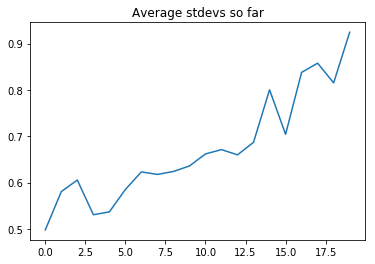

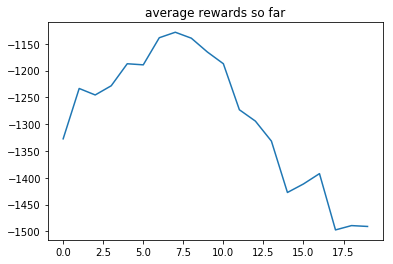

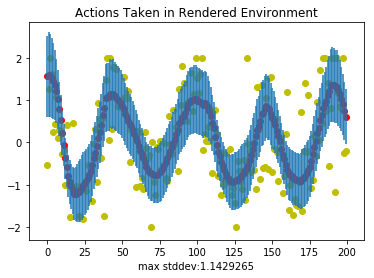

20
average reward:  -1469.2449656491394 stdevs: 0.9358659 losses: 2.9083045
21
average reward:  -1558.603581843629 stdevs: 0.84266025 losses: 1.9096264
22
average reward:  -1610.3890292548047 stdevs: 0.9637836 losses: 1.6739645
23
average reward:  -1564.0886158321177 stdevs: 0.96123254 losses: 1.4283106
24
average reward:  -1532.4203647605032 stdevs: 1.0364871 losses: 0.9858414
25
average reward:  -1460.1166302700917 stdevs: 0.979469 losses: 0.78061557
26
average reward:  -1504.1281939463188 stdevs: 0.7775502 losses: 0.8769376
27
average reward:  -1468.0007719346534 stdevs: 0.857398 losses: 0.95254517
28
average reward:  -1490.2895452802106 stdevs: 0.6874614 losses: 0.6217624
29
average reward:  -1457.0085082558028 stdevs: 0.6472118 losses: 0.75207895
30
average reward:  -1414.246500385485 stdevs: 0.8657518 losses: 0.2044187
31
average reward:  -1433.4334471869463 stdevs: 0.6393056 losses: 0.72877073
32
average reward:  -1448.8391821296461 stdevs: 0.5955303 losses: 0.49844944
33
averag

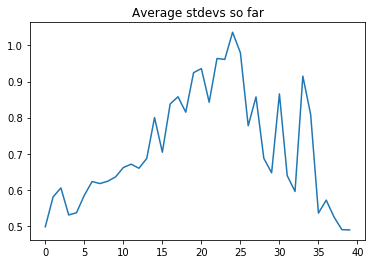

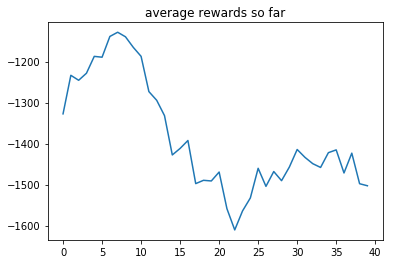

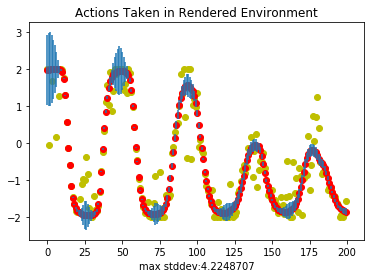

40
average reward:  -1463.1134288220444 stdevs: 0.4906209 losses: 0.39130014
41
average reward:  -1476.7949652376205 stdevs: 0.48378015 losses: 0.24287878
42
average reward:  -1506.210616891348 stdevs: 0.58081603 losses: -0.04931571
43
average reward:  -1502.2793518511899 stdevs: 0.48470572 losses: -0.19407625
44
average reward:  -1455.9876890393891 stdevs: 0.4713607 losses: 0.32172957
45
average reward:  -1523.9707689178654 stdevs: 0.4782116 losses: 0.13928506
46
average reward:  -1484.480126685047 stdevs: 0.49373385 losses: 0.3948692
47
average reward:  -1544.5224524086564 stdevs: 0.5989372 losses: 0.41391966
48
average reward:  -1549.8019555201831 stdevs: 0.5619995 losses: 0.08972421
49
average reward:  -1542.813687372417 stdevs: 0.55848587 losses: 0.047286484
50
average reward:  -1517.85477468843 stdevs: 0.69713604 losses: 0.31601202
51
average reward:  -1507.4162079718467 stdevs: 0.6498134 losses: -0.097350165
52
average reward:  -1490.6453794662225 stdevs: 0.63365716 losses: 0.01

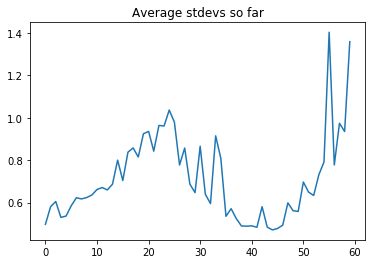

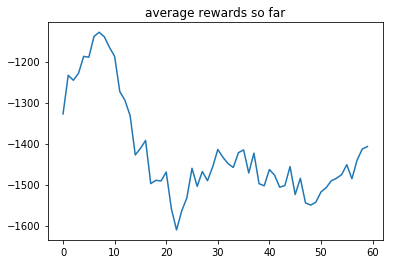

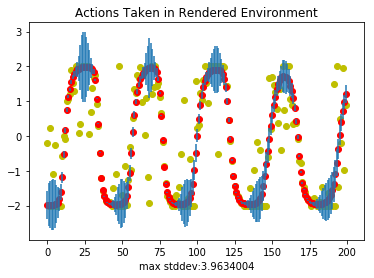

60
average reward:  -1271.5910280331639 stdevs: 0.9729283 losses: 0.39353445
61
average reward:  -1289.5517053099386 stdevs: 1.1282668 losses: 0.26462922
62
average reward:  -1177.3718798901016 stdevs: 2.003129 losses: 0.17271954
63
average reward:  -1040.3507539582104 stdevs: 2.0266123 losses: 1.5029311
64
average reward:  -991.8448004081314 stdevs: 1.7441124 losses: -0.6769473
65
average reward:  -974.445814101058 stdevs: 1.887614 losses: -0.9689018
66
average reward:  -990.0403929335844 stdevs: 1.4905764 losses: -0.39758077
67
average reward:  -1062.2172181774652 stdevs: 1.6310748 losses: -0.80229706
68
average reward:  -1072.3000133526025 stdevs: 2.0998614 losses: -1.4861631
69
average reward:  -1074.5396709270062 stdevs: 2.2199924 losses: -1.5847275
70
average reward:  -1034.280568364857 stdevs: 1.692814 losses: 0.21680887
71
average reward:  -1076.918542840874 stdevs: 2.225251 losses: -0.8563644
72
average reward:  -1054.4746220604 stdevs: 0.89865696 losses: -0.1041529
73
average

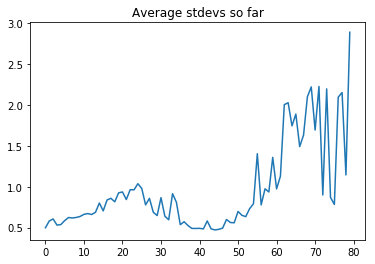

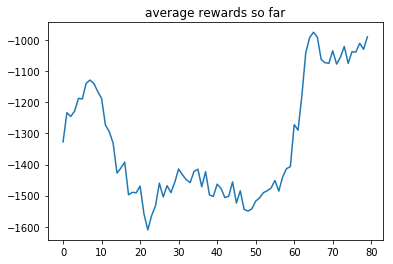

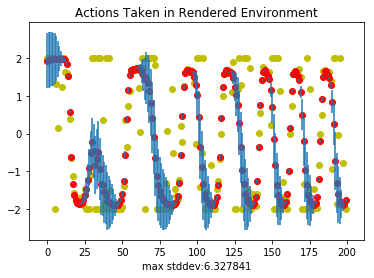

80
average reward:  -989.0619939075332 stdevs: 1.4083092 losses: 0.33126405
81
average reward:  -1006.2429649525187 stdevs: 2.0958526 losses: -1.0047386
82
average reward:  -977.2255521532772 stdevs: 1.3839482 losses: 0.12777217
83
average reward:  -953.1866009510592 stdevs: 1.728982 losses: -1.1178095
84
average reward:  -965.9403850475504 stdevs: 2.180251 losses: -1.8601135
85
average reward:  -894.8281270727845 stdevs: 1.7174516 losses: 1.3434737
86
average reward:  -959.4602586823141 stdevs: 0.89743686 losses: -0.09556048
87
average reward:  -933.6773123256655 stdevs: 1.942391 losses: -0.40009713
88
average reward:  -871.158545657765 stdevs: 1.4480613 losses: -0.68085223
89
average reward:  -939.613835332006 stdevs: 1.2372802 losses: -0.053057417
90
average reward:  -937.4028538815398 stdevs: 1.0811177 losses: -0.57828385
91
average reward:  -991.5765231107043 stdevs: 2.4325094 losses: -0.36065003
92
average reward:  -998.037214068148 stdevs: 1.1202514 losses: -0.58473265
93
averag

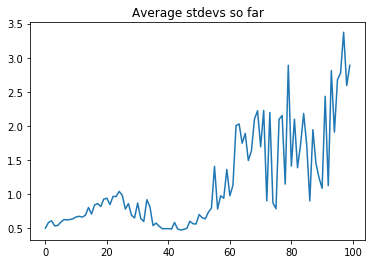

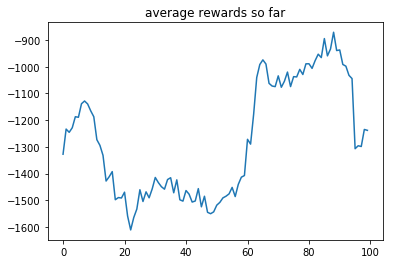

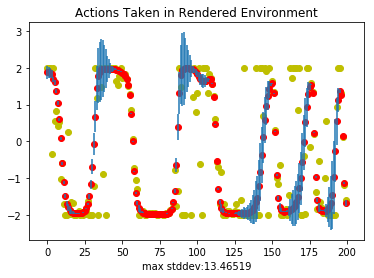

100
average reward:  -1186.2951565685642 stdevs: 3.4568172 losses: -1.1982026
101
average reward:  -1225.4262636176186 stdevs: 4.3852773 losses: -0.85924053
102
average reward:  -1237.1209520005546 stdevs: 3.9123461 losses: -0.7332651
103
average reward:  -1222.6286020064315 stdevs: 5.8587685 losses: 1.0027938
104
average reward:  -1229.0338536732684 stdevs: 5.2639804 losses: -0.85540307
105
average reward:  -1244.4025788239646 stdevs: 6.0910316 losses: 0.08070724
106
average reward:  -1210.619120396364 stdevs: 7.112469 losses: 0.7919143
107
average reward:  -1216.1697867400378 stdevs: 7.015852 losses: -0.11275848
108
average reward:  -1239.305982387227 stdevs: 7.374492 losses: 0.10819103
109
average reward:  -1203.0968076626411 stdevs: 7.7111926 losses: -0.13819124
110
average reward:  -1194.066874999461 stdevs: 6.4242563 losses: -0.17110592
111
average reward:  -1173.290154129357 stdevs: 6.3651767 losses: -0.84284204
112
average reward:  -1179.0856131462601 stdevs: 7.015813 losses: -

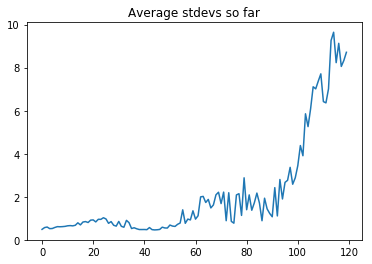

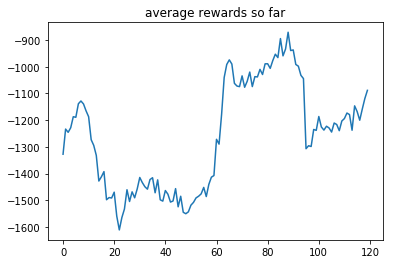

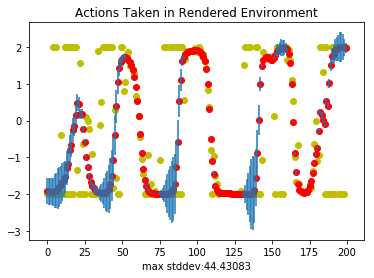

120
average reward:  -1090.6747817822368 stdevs: 7.2199984 losses: -0.017153606
121
average reward:  -1103.563328614367 stdevs: 6.748057 losses: 0.36470538
122
average reward:  -1064.1712491564722 stdevs: 8.317011 losses: 0.043653976
123
average reward:  -966.8555313114223 stdevs: 6.543018 losses: -1.1562791
124
average reward:  -1035.7259329277265 stdevs: 6.4146795 losses: -0.28646412
125
average reward:  -1018.6563046022917 stdevs: 10.357422 losses: 1.2590127
126
average reward:  -972.951757387403 stdevs: 5.990324 losses: -0.0066527673
127
average reward:  -841.7731882393098 stdevs: 7.372161 losses: 0.08200669
128
average reward:  -801.3748983427115 stdevs: 8.384877 losses: -0.042630862
129
average reward:  -729.477570064177 stdevs: 14.011441 losses: 2.6018171
130
average reward:  -673.9672848339242 stdevs: 0.58047056 losses: -3.141218
131
average reward:  -702.1149261830276 stdevs: 0.11923036 losses: -3.228515
Saving the model after finding last 10 average rewards of: -880.706864304

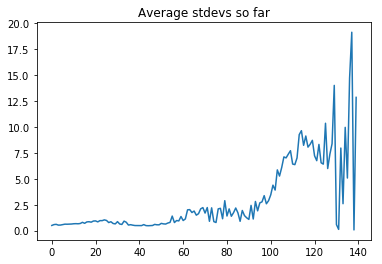

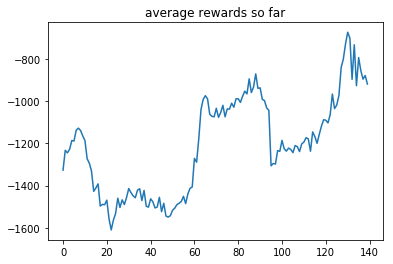

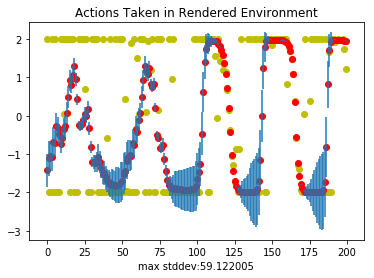

140
average reward:  -805.5902665439941 stdevs: 27.551449 losses: 1.9427605
141
average reward:  -925.0162395071515 stdevs: 29.419907 losses: 1.7531536
142
average reward:  -1074.0508386943025 stdevs: 12.702617 losses: -0.7128537
143
average reward:  -992.2948811165877 stdevs: 0.056359075 losses: -3.0208554
144
average reward:  -941.4161987189258 stdevs: 5.4368043 losses: -2.8549497
145
average reward:  -1058.7298466096809 stdevs: 28.10134 losses: 1.1026716
146
average reward:  -887.2979963494265 stdevs: 0.12054704 losses: -2.3379548
147
average reward:  -1068.4209917364117 stdevs: 19.175 losses: 2.8010342
148
average reward:  -1061.9743988362818 stdevs: 4.353222 losses: -3.4677992
149
average reward:  -1022.8315696057741 stdevs: 38.3901 losses: 0.91687334
150
average reward:  -1056.480683751813 stdevs: 0.13326187 losses: -4.0906777
151
average reward:  -930.6754084268377 stdevs: 39.917164 losses: 1.0897393
152
average reward:  -960.0934892034957 stdevs: 20.948984 losses: 0.9478361
153

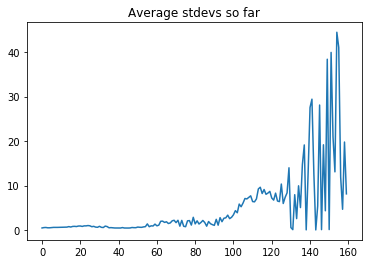

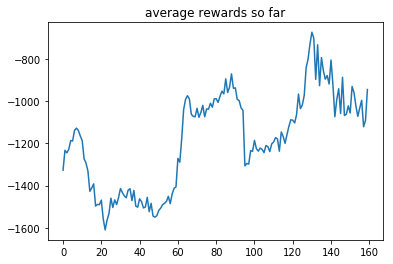

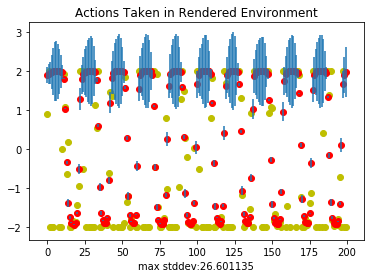

160
average reward:  -1006.9571066937724 stdevs: 45.937145 losses: 0.43673602
161
average reward:  -1104.458217302177 stdevs: 35.386456 losses: 0.42049804
162
average reward:  -928.7310989817197 stdevs: 0.09491151 losses: -4.1480093
163
average reward:  -990.5772743664011 stdevs: 7.1348357 losses: -3.0284576
164
average reward:  -1080.2030508194205 stdevs: 0.10185241 losses: -3.0993738
165
average reward:  -1073.1120635274806 stdevs: 12.002446 losses: 1.5696166
166
average reward:  -1089.8077087450558 stdevs: 48.6048 losses: 0.29052413
167
average reward:  -998.3557387370789 stdevs: 38.306248 losses: -0.28354362
168
average reward:  -1003.092298839481 stdevs: 49.184055 losses: 0.06923641
169
average reward:  -1028.6901118644103 stdevs: 22.886189 losses: 0.7024181
170
average reward:  -935.2518198587688 stdevs: 20.761824 losses: 1.0221901
171
average reward:  -1087.4137063665653 stdevs: 41.397614 losses: -0.08683622
172
average reward:  -914.9062445492779 stdevs: 10.418387 losses: 1.229

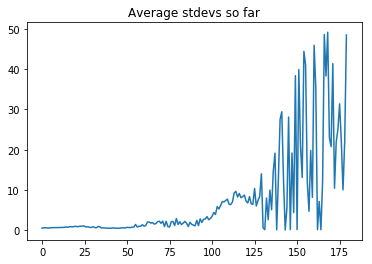

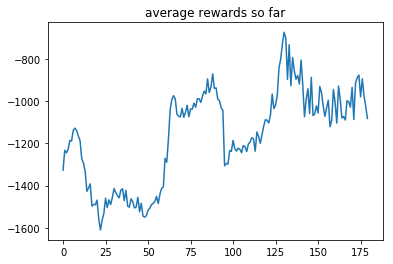

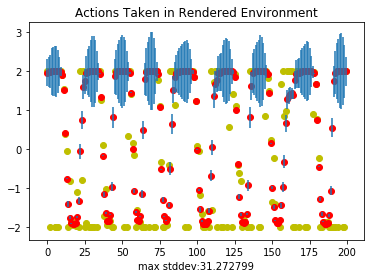

180
average reward:  -901.8956278429989 stdevs: 6.993715 losses: -3.5765035
181
average reward:  -775.990962791226 stdevs: 0.119435236 losses: -3.8688903
182
average reward:  -879.8557836347376 stdevs: 24.14136 losses: 1.5169114
183
average reward:  -931.5987190650551 stdevs: 49.208042 losses: 1.0343897
184
average reward:  -824.9113973072356 stdevs: 27.259014 losses: -0.86554515
185
average reward:  -841.9594496732177 stdevs: 12.199704 losses: -1.7752306
186
average reward:  -902.1576393904431 stdevs: 40.138916 losses: 1.1119897
187
average reward:  -902.230460616391 stdevs: 5.365603 losses: -3.1212904
188
average reward:  -956.1935930279317 stdevs: 47.528698 losses: 0.36095104
Saving the model after finding last 10 average rewards of: -899.9108038450464
189
average reward:  -823.0695206513647 stdevs: 19.591805 losses: -1.7801669
190
average reward:  -907.4846293337547 stdevs: 0.48672724 losses: -2.7495258
191
average reward:  -896.7609718312885 stdevs: 22.984129 losses: -0.3614219
19

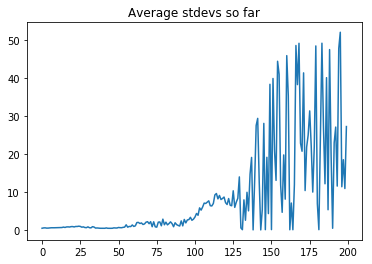

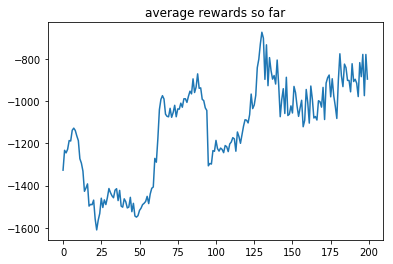

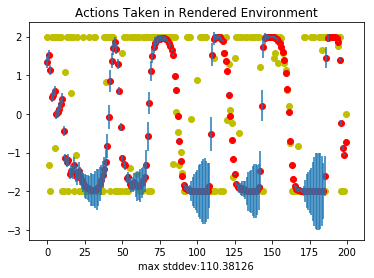

200
average reward:  -790.7323570994704 stdevs: 6.132534 losses: -2.964461
201
average reward:  -799.8792585644245 stdevs: 43.11994 losses: 0.44264287
202
average reward:  -805.621649784747 stdevs: 28.209585 losses: 1.2457414
203
average reward:  -845.7943081385965 stdevs: 56.657024 losses: 1.822104
204
average reward:  -854.6855536478155 stdevs: 21.051939 losses: -0.5973107
205
average reward:  -844.8760043830671 stdevs: 6.5617247 losses: -2.2450197
206
average reward:  -901.2789765591435 stdevs: 12.795908 losses: -1.5315791
207
average reward:  -932.10844704802 stdevs: 0.43451312 losses: -2.8154926
208
average reward:  -849.7457768867018 stdevs: 29.711786 losses: 1.721383
209
average reward:  -835.630320772974 stdevs: 30.002243 losses: 1.1757032
210
average reward:  -864.0678486225679 stdevs: 45.142437 losses: 0.9386006
211
average reward:  -856.6891138228068 stdevs: 21.453165 losses: 1.0500188
212
average reward:  -865.0139914768151 stdevs: 0.05487022 losses: -2.7523704
213
average 

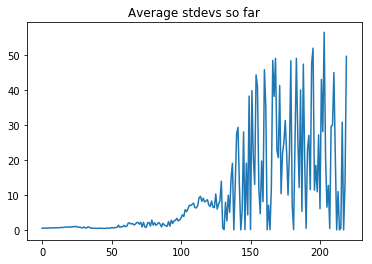

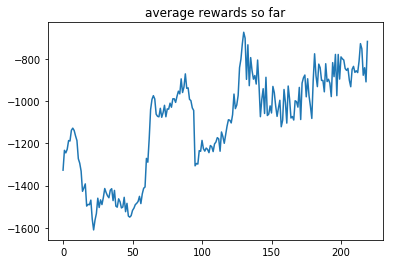

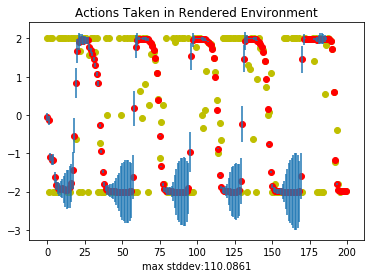

220
average reward:  -894.8619455101428 stdevs: 1.0278244 losses: -2.445658
221
average reward:  -924.3135524911735 stdevs: 28.455883 losses: 2.6599402
222
average reward:  -995.0455244446554 stdevs: 19.016584 losses: 1.4545784
223
average reward:  -856.6710212337952 stdevs: 5.981401 losses: -1.7785046
224
average reward:  -862.3798655153556 stdevs: 51.84252 losses: 0.55688936
225
average reward:  -906.4466711973513 stdevs: 41.887028 losses: 0.79245377
226
average reward:  -937.148599844392 stdevs: 29.564075 losses: 1.9917828
227
average reward:  -727.6687345375215 stdevs: 28.430105 losses: 1.7148677
228
average reward:  -812.5460914291491 stdevs: 46.96644 losses: 1.297108
229
average reward:  -739.9426086759173 stdevs: 10.338777 losses: 1.9174927
230
average reward:  -855.8064587648281 stdevs: 39.663174 losses: 1.2046149
231
average reward:  -740.3563236378121 stdevs: 42.522427 losses: 0.8088494
232
average reward:  -829.9051355589961 stdevs: 21.838663 losses: 0.71198964
233
average r

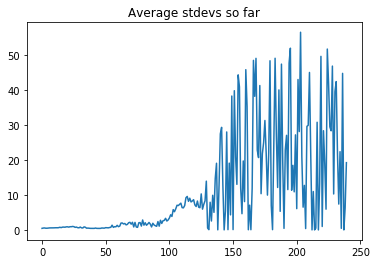

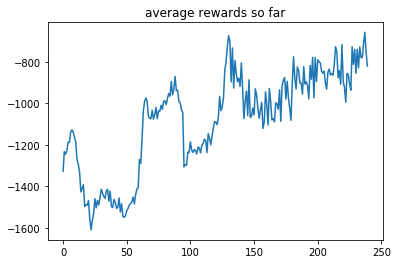

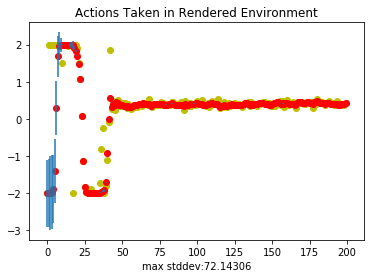

240
average reward:  -1006.8325625309286 stdevs: 17.151552 losses: 3.8055234
241
average reward:  -1192.0259341287444 stdevs: 17.916916 losses: 1.7423673
242
average reward:  -873.6702197453284 stdevs: 14.428196 losses: 1.7817429
243
average reward:  -853.8249868735435 stdevs: 18.75223 losses: 1.3563821
244
average reward:  -876.8262171204993 stdevs: 16.07128 losses: 0.4589881
245
average reward:  -847.5790633718067 stdevs: 25.256002 losses: 1.282987
246
average reward:  -851.2730041058807 stdevs: 19.561016 losses: 1.2425174
247
average reward:  -792.1961638623495 stdevs: 35.205357 losses: -0.8233405
248
average reward:  -926.1797041509013 stdevs: 0.054025084 losses: -2.9388125
249
average reward:  -853.6710343768658 stdevs: 22.40468 losses: -0.14211628
250
average reward:  -816.4938869016421 stdevs: 52.508667 losses: 0.5608488
251
average reward:  -880.129006115305 stdevs: 12.092305 losses: 1.1876916
252
average reward:  -822.9428210045222 stdevs: 15.682947 losses: 1.6160834
253
avera

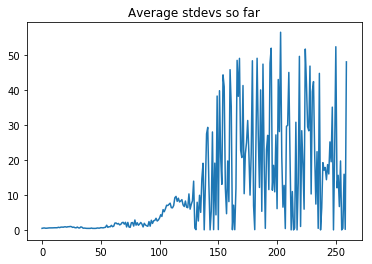

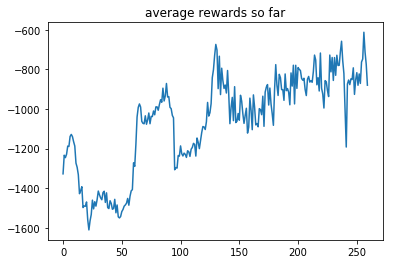

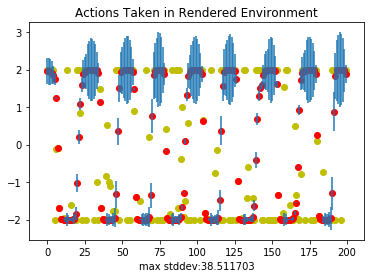

260
average reward:  -682.5659160231046 stdevs: 26.413603 losses: -0.7642365
261
average reward:  -809.1740557682097 stdevs: 19.798742 losses: 1.2895303
262
average reward:  -957.7434540456521 stdevs: 15.5978775 losses: 0.7448526
263
average reward:  -934.840949540876 stdevs: 6.956691 losses: -2.6474104
264
average reward:  -841.8280949392692 stdevs: 12.20187 losses: 1.9600295
265
average reward:  -878.963686918982 stdevs: 16.24841 losses: 1.2837512
266
average reward:  -741.5321738489138 stdevs: 9.07991 losses: -0.004376464
267
average reward:  -710.9574594152347 stdevs: 0.22285074 losses: -0.9990389
268
average reward:  -875.4065675479266 stdevs: 12.197511 losses: 2.1737845
269
average reward:  -563.9802678440043 stdevs: 19.423975 losses: 2.0173938
270
average reward:  -595.1345741719413 stdevs: 0.25706282 losses: -0.2714346
271
average reward:  -748.1177366800014 stdevs: 5.400823 losses: -1.4586589
272
average reward:  -786.4714153293397 stdevs: 15.48853 losses: 2.2258282
273
averag

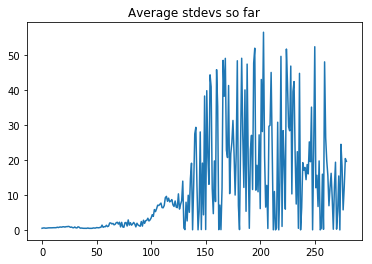

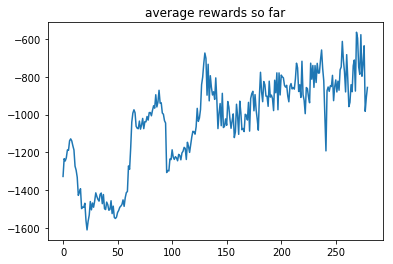

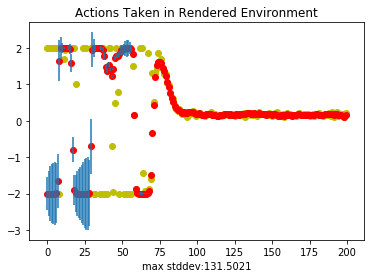

280
average reward:  -770.4095314900613 stdevs: 0.028549649 losses: -2.3660223
281
average reward:  -781.0903940902184 stdevs: 5.890452 losses: -0.95681816
282
average reward:  -782.90925585757 stdevs: 11.094368 losses: 2.76978
283
average reward:  -508.8803636917654 stdevs: 17.24205 losses: 0.7567894
284
average reward:  -719.9830129423781 stdevs: 10.804508 losses: -1.2246178
285
average reward:  -774.7673893172953 stdevs: 54.365147 losses: 2.2189465
286
average reward:  -776.6929964930723 stdevs: 13.190577 losses: 3.2109678
287
average reward:  -775.9989232596631 stdevs: 58.325504 losses: 1.8315369
288
average reward:  -780.8576476837014 stdevs: 14.68655 losses: -1.4434243
289
average reward:  -757.9537719382431 stdevs: 7.3337293 losses: 1.6242533
290
average reward:  -1115.1135825784463 stdevs: 9.299047 losses: 1.2754759
Saving the model after finding last 10 average rewards of: -777.4247337852354
291
average reward:  -1122.8570182905944 stdevs: 15.407506 losses: 1.2497271
292
avera

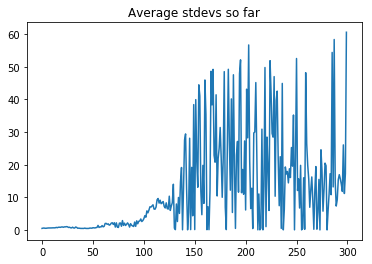

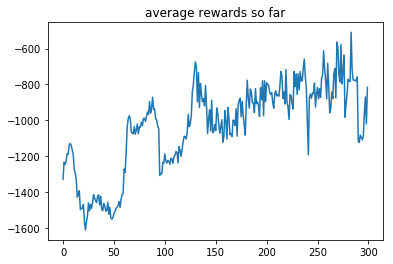

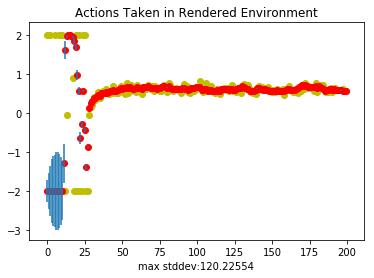

300
average reward:  -907.7092824543139 stdevs: 6.94429 losses: -2.5667953
301
average reward:  -897.3108309448183 stdevs: 5.3316936 losses: -0.13202387
302
average reward:  -1104.7004905574165 stdevs: 60.570538 losses: 1.5904168
303
average reward:  -1115.1260859125164 stdevs: 23.436377 losses: -0.03164144
304
average reward:  -1076.3083496700608 stdevs: 11.901046 losses: 0.59922
305
average reward:  -1157.5904469649718 stdevs: 44.577785 losses: -0.12351273
306
average reward:  -1137.677325851686 stdevs: 28.054962 losses: 1.850056
307
average reward:  -1063.7321784315777 stdevs: 10.680885 losses: -0.4831131
308
average reward:  -1092.1199544013703 stdevs: 22.226896 losses: 0.40403703
309
average reward:  -1129.479181085465 stdevs: 22.3573 losses: -0.5933809
310
average reward:  -1080.6565849353988 stdevs: 13.9043 losses: -0.030398622
311
average reward:  -1099.868465181838 stdevs: 17.342249 losses: -0.3804076
312
average reward:  -1070.0693301088297 stdevs: 27.655607 losses: 2.1553648

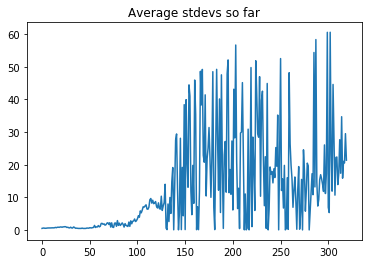

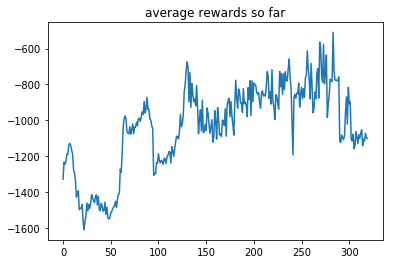

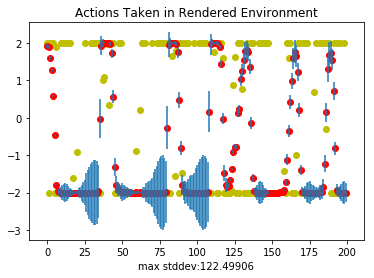

320
average reward:  -1096.0983143184305 stdevs: 19.64064 losses: -0.58896947
321
average reward:  -1048.3683417218003 stdevs: 25.264708 losses: -0.011857455
322
average reward:  -1030.335861266224 stdevs: 25.749382 losses: 0.77412915
323
average reward:  -1087.3881812643212 stdevs: 27.955513 losses: -0.034136686
324
average reward:  -1035.630625230633 stdevs: 24.826246 losses: -0.231862
325
average reward:  -1001.9544072317079 stdevs: 23.579975 losses: -0.612536
326
average reward:  -1044.11577724427 stdevs: 30.631165 losses: -0.54886556
327
average reward:  -1003.5663598548699 stdevs: 41.472584 losses: 0.504589
328
average reward:  -1064.8656697979882 stdevs: 26.447515 losses: 0.51591545
329
average reward:  -1031.3307415735367 stdevs: 24.197157 losses: -0.71319205
330
average reward:  -1006.3395848139924 stdevs: 28.611034 losses: -0.43397814
331
average reward:  -980.707884929566 stdevs: 24.558405 losses: 2.288242
332
average reward:  -1036.3826674835814 stdevs: 34.574726 losses: 0.

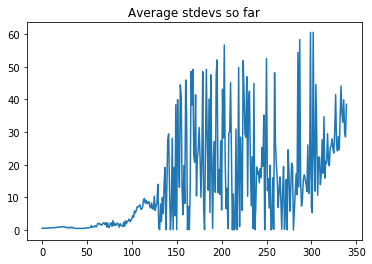

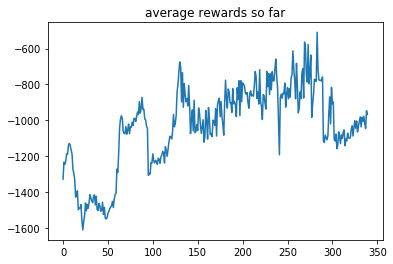

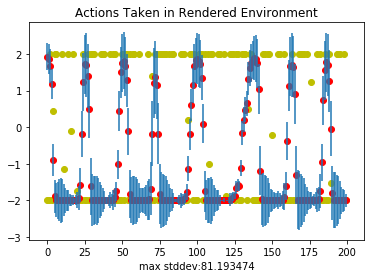

340
average reward:  -976.843441918214 stdevs: 28.587229 losses: 0.17789987
341
average reward:  -1014.0057773577635 stdevs: 31.474007 losses: 0.049796723
342
average reward:  -972.9770213438703 stdevs: 48.784313 losses: -0.30113915
343
average reward:  -1008.3154927090789 stdevs: 38.977055 losses: 0.0009717989
344
average reward:  -954.2491754574021 stdevs: 36.717094 losses: -0.1050046
345
average reward:  -999.8182789497456 stdevs: 33.14309 losses: 0.32346624
346
average reward:  -971.4476914472668 stdevs: 47.32347 losses: -0.106158786
347
average reward:  -954.7751800724403 stdevs: 25.327913 losses: 0.2592045
348
average reward:  -1014.3291386491558 stdevs: 36.27528 losses: -0.49243337
349
average reward:  -959.0072058345565 stdevs: 28.74206 losses: 0.015453339
350
average reward:  -960.3638399738595 stdevs: 32.689594 losses: -0.10634242
351
average reward:  -920.0180963374441 stdevs: 34.168854 losses: -0.6251271
352
average reward:  -923.08804881375 stdevs: 32.253643 losses: 0.4768

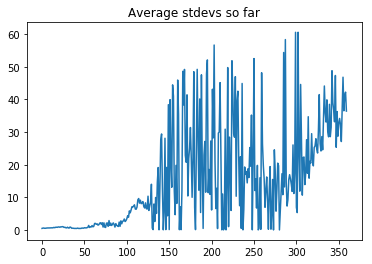

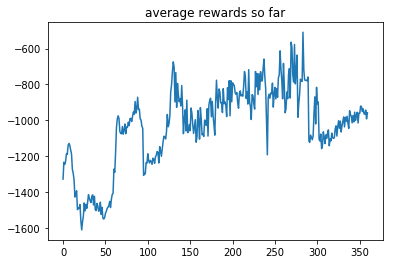

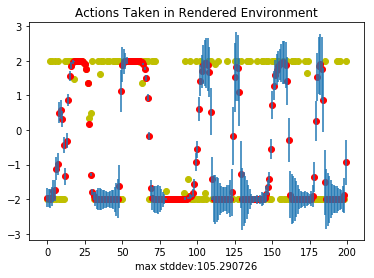

360
average reward:  -967.5682965282165 stdevs: 35.136173 losses: -0.89333916
361
average reward:  -904.2911501963575 stdevs: 35.6919 losses: -0.5824022
362
average reward:  -983.9895536085611 stdevs: 33.06812 losses: 0.16421796
363
average reward:  -917.9889863210981 stdevs: 34.467632 losses: -1.0554389
364
average reward:  -916.398330361087 stdevs: 49.389816 losses: 0.47987953
365
average reward:  -933.0156963690712 stdevs: 44.324154 losses: 0.45274702
366
average reward:  -968.4645787745892 stdevs: 46.366524 losses: -0.40929142
367
average reward:  -905.0497921106429 stdevs: 34.216812 losses: -0.1238691
368
average reward:  -947.23275779026 stdevs: 52.055573 losses: 0.8037948
369
average reward:  -911.437514931467 stdevs: 48.344673 losses: 0.45724434
370
average reward:  -939.7869514918642 stdevs: 56.778866 losses: 0.4289721
371
average reward:  -953.0454986840456 stdevs: 62.187344 losses: 0.5128482
372
average reward:  -940.7511884908206 stdevs: 72.69407 losses: -0.3020879
373
aver

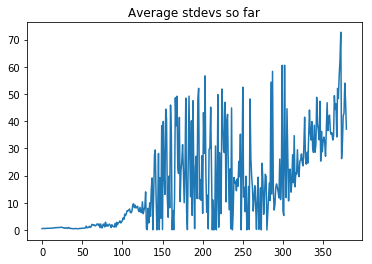

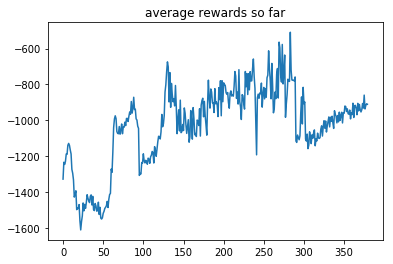

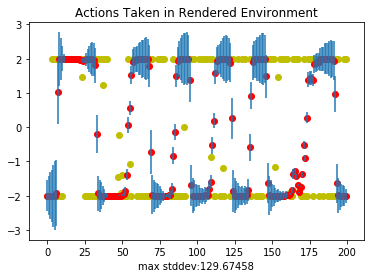

380
average reward:  -883.292533640376 stdevs: 35.91526 losses: 0.22018808
381
average reward:  -867.2355601389202 stdevs: 31.429619 losses: -1.2432126
382
average reward:  -922.8301346154221 stdevs: 28.769754 losses: -1.4056677
383
average reward:  -909.1991149805523 stdevs: 20.726864 losses: 1.1168648
384
average reward:  -855.8472694142216 stdevs: 51.188843 losses: -0.5374783
Saving the model after finding last 10 average rewards of: -896.8350271161207
385
average reward:  -891.4664833589848 stdevs: 39.79916 losses: -0.6021537
386
average reward:  -870.1243824785473 stdevs: 38.061577 losses: -1.024814
387
average reward:  -888.2144032603459 stdevs: 39.307846 losses: -0.55521363
388
average reward:  -826.8928101313375 stdevs: 41.982273 losses: 0.34404993
389
average reward:  -843.9478273267111 stdevs: 35.045116 losses: 1.1258913
390
average reward:  -860.6334651706948 stdevs: 24.985415 losses: -1.228977
391
average reward:  -794.9028545179647 stdevs: 30.801165 losses: 0.49377427
392


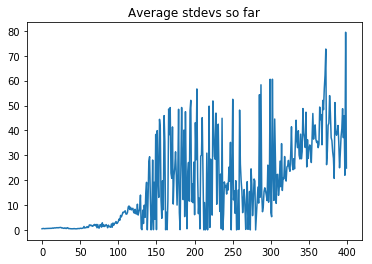

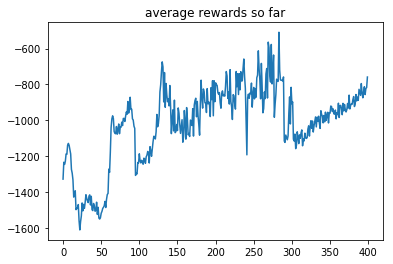

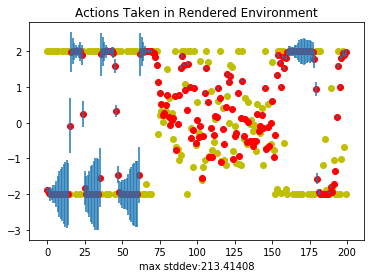

400
average reward:  -718.3332361372512 stdevs: 39.86971 losses: 0.8003508
401
average reward:  -684.2736657439073 stdevs: 18.1535 losses: -1.1326492
402
average reward:  -533.2934584001144 stdevs: 27.506725 losses: -0.69282746
403
average reward:  -601.013224744163 stdevs: 41.216747 losses: -0.059160452
404
average reward:  -415.3992551608797 stdevs: 17.23132 losses: -0.82674366
405
average reward:  -355.30809116439207 stdevs: 21.188171 losses: -0.93185157
406
average reward:  -332.1496906652063 stdevs: 17.271875 losses: -0.10827151
407
average reward:  -474.2092246616588 stdevs: 17.622154 losses: 0.015919173
408
average reward:  -392.27202528108467 stdevs: 3.1350687 losses: -1.443068
409
average reward:  -434.6559780069518 stdevs: 6.0967507 losses: -1.2499518
410
average reward:  -519.9658941613577 stdevs: 3.7875957 losses: -1.3126371
411
average reward:  -452.38549348960544 stdevs: 1.6469846 losses: -1.6340455
412
average reward:  -489.42914478696247 stdevs: 0.12141821 losses: -1.24

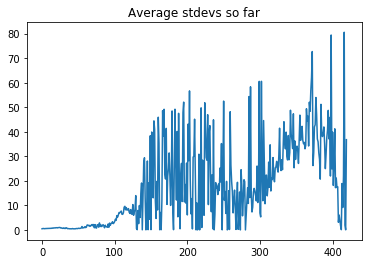

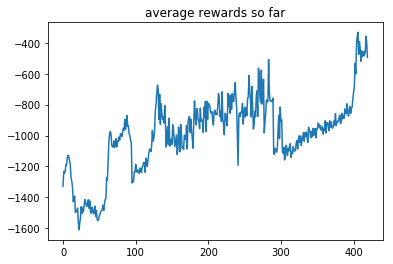

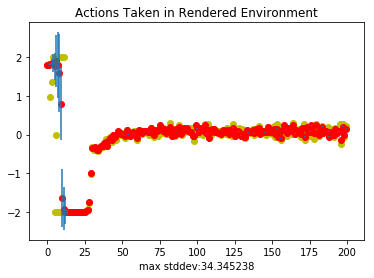

420
average reward:  -505.00275157627004 stdevs: 0.4146559 losses: -0.80223584
421
average reward:  -508.4009749502422 stdevs: 8.81667 losses: -0.84291434
422
average reward:  -537.7026839406583 stdevs: 7.527198 losses: -0.7882749
423
average reward:  -549.2459806075751 stdevs: 1.7568249 losses: -1.1520283
424
average reward:  -407.2492905116898 stdevs: 4.0088406 losses: -0.46516976
425
average reward:  -408.05112637483694 stdevs: 6.7948704 losses: -0.24439315
426
average reward:  -487.3040643599221 stdevs: 17.591002 losses: 0.14630948
427
average reward:  -446.6608690823423 stdevs: 11.628481 losses: 0.43605593
428
average reward:  -446.39917782351597 stdevs: 35.412746 losses: 3.1321461
429
average reward:  -564.9240615722852 stdevs: 7.4365215 losses: -0.10618136
430
average reward:  -422.8425620773058 stdevs: 71.09501 losses: 2.2377486
431
average reward:  -427.134139325455 stdevs: 6.2886577 losses: -0.7221969
432
average reward:  -520.4452718893106 stdevs: 0.026365386 losses: -0.2292

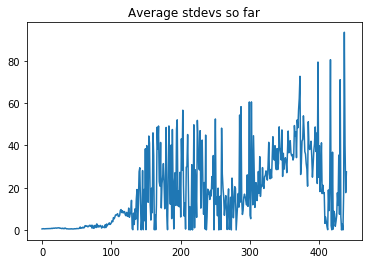

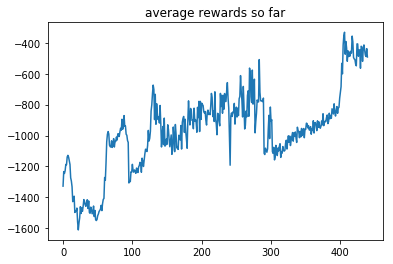

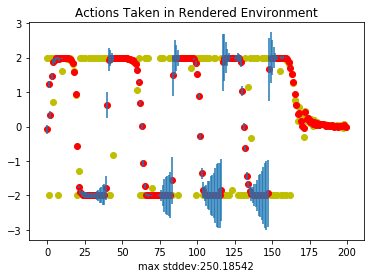

440
average reward:  -419.7634941730068 stdevs: 15.408718 losses: -0.29637954
441
average reward:  -518.8528716221326 stdevs: 0.029867547 losses: -0.69347125
442
average reward:  -458.46001670163093 stdevs: 9.141624 losses: -0.03891896
443
average reward:  -448.70288104507216 stdevs: 105.84241 losses: 2.357935
444
average reward:  -517.9978880545777 stdevs: 29.819065 losses: 1.9056818
445
average reward:  -387.7062412401113 stdevs: 5.3402534 losses: -0.25410038
446
average reward:  -518.1631925134361 stdevs: 7.9587073 losses: -1.3929455
447
average reward:  -464.48911511763833 stdevs: 55.628082 losses: 0.88036066
448
average reward:  -520.7604490454212 stdevs: 49.566563 losses: 2.139133
449
average reward:  -502.49091686411896 stdevs: 1.4479398 losses: -0.7134924
450
average reward:  -424.43757392970076 stdevs: 11.54575 losses: 0.4550265
451
average reward:  -520.8269178286444 stdevs: 14.198209 losses: 1.1498637
452
average reward:  -426.3499468643164 stdevs: 23.296179 losses: 1.177290

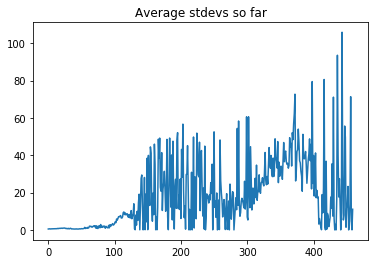

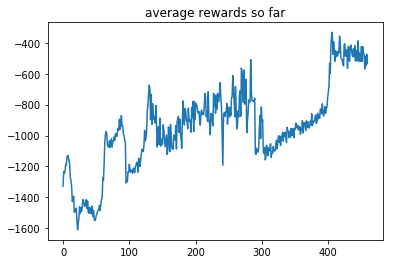

460
average reward:  -426.2358271012179 stdevs: 9.443555 losses: -0.60005814
461
average reward:  -485.97959425524704 stdevs: 21.368086 losses: 1.9326444
462
average reward:  -382.49391832310255 stdevs: 0.4480383 losses: -0.8963886
463
average reward:  -413.5467232323934 stdevs: 16.342707 losses: 0.17763184
464
average reward:  -592.5168038093577 stdevs: 0.7643631 losses: -0.46817082
465
average reward:  -488.7487130838296 stdevs: 10.600097 losses: 0.20759968
466
average reward:  -464.55479003009987 stdevs: 126.06931 losses: 3.7468581
467
average reward:  -673.901819306391 stdevs: 0.70844173 losses: -1.0845317
468
average reward:  -487.6815239453187 stdevs: 7.2252192 losses: -0.33300513
469
average reward:  -398.75485848733996 stdevs: 25.167963 losses: -0.64062345
470
average reward:  -463.6650369084383 stdevs: 19.963346 losses: 1.1107843
471
average reward:  -497.58783279147536 stdevs: 30.58163 losses: 3.8205726
472
average reward:  -495.5143893123568 stdevs: 6.7097754 losses: -1.4130

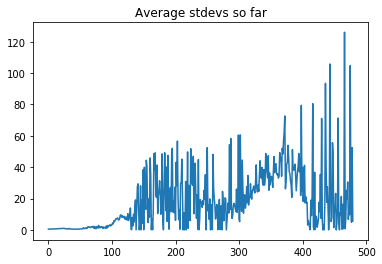

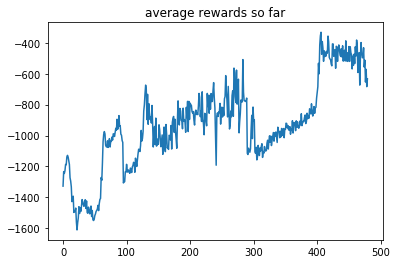

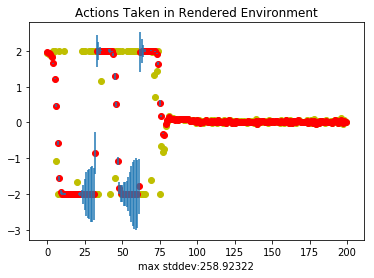

480
average reward:  -760.679494169344 stdevs: 11.664003 losses: -0.6394324
481
average reward:  -639.2928636793154 stdevs: 104.809204 losses: 2.4392965
482
average reward:  -601.0386498374558 stdevs: 91.1718 losses: 1.7412753
483
average reward:  -547.8905987181091 stdevs: 10.13048 losses: -0.61693543
484
average reward:  -529.3439285539471 stdevs: 4.6864395 losses: -0.96097904
485
average reward:  -664.4529158191434 stdevs: 36.925915 losses: -0.44992882
486
average reward:  -601.594551775633 stdevs: 13.4550495 losses: -0.8402584
Saving the model after finding last 10 average rewards of: -623.4260153126062
487
average reward:  -541.7049705210617 stdevs: 0.66659194 losses: -0.4581865
488
average reward:  -620.7340820277093 stdevs: 25.20872 losses: 1.6885601
489
average reward:  -570.6495424341252 stdevs: 7.4283023 losses: -0.9514607
490
average reward:  -699.8322577356071 stdevs: 0.43970552 losses: -1.5992384
491
average reward:  -674.9777931033842 stdevs: 26.358433 losses: 2.6489632
4

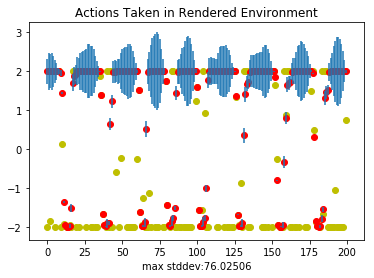

500
average reward:  -666.329213703346 stdevs: 0.020854557 losses: -0.0774317
501
average reward:  -539.296398812033 stdevs: 0.44775897 losses: 0.028211212
502
average reward:  -385.68562003072736 stdevs: 13.784624 losses: -0.8746262
503
average reward:  -500.80530030017997 stdevs: 1.6236584 losses: -0.21916859
504
average reward:  -589.0919111430201 stdevs: 6.8001876 losses: -0.058625784
505
average reward:  -490.43199889477944 stdevs: 20.495749 losses: 1.2361343
506
average reward:  -459.64489969623594 stdevs: 0.48612657 losses: 0.03528694
507
average reward:  -512.0968061124946 stdevs: 16.542847 losses: 0.92965907
508
average reward:  -400.6668970390635 stdevs: 75.460144 losses: 2.495338
509
average reward:  -412.3474039480212 stdevs: 8.515698 losses: -1.2480004
510
average reward:  -564.1949143426294 stdevs: 9.095374 losses: -0.66563284
511
average reward:  -409.83373932163965 stdevs: 6.1314654 losses: -0.43794855
512
average reward:  -436.1116715053454 stdevs: 51.864655 losses: 0.

520
average reward:  -508.0360913400676 stdevs: 9.625301 losses: -0.58655334
521
average reward:  -548.1413588523707 stdevs: 99.037 losses: 1.1810423
522
average reward:  -582.4907410298085 stdevs: 32.6932 losses: 3.3944743
523
average reward:  -606.5903264218257 stdevs: 9.557259 losses: 0.13662888
524
average reward:  -462.081172495357 stdevs: 14.181079 losses: -0.47717634
525
average reward:  -513.3494328893103 stdevs: 24.072403 losses: 0.47405416
526
average reward:  -480.0774081671469 stdevs: 0.65956044 losses: -1.0103568
527
average reward:  -594.3214980032503 stdevs: 1.0158794 losses: -1.5267864
528
average reward:  -467.4456642572371 stdevs: 0.07287464 losses: -0.8742358
529
average reward:  -416.2611757025882 stdevs: 16.465275 losses: 1.1521736
530
average reward:  -595.0968670891515 stdevs: 13.198705 losses: -0.26608312
531
average reward:  -543.9415613787471 stdevs: 1.1582234 losses: -1.1042073
532
average reward:  -530.0668524016321 stdevs: 26.775717 losses: -0.12098366
533


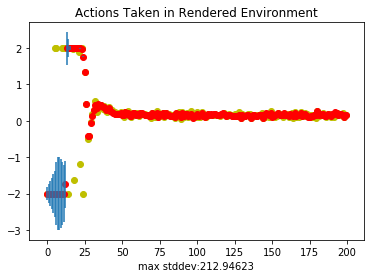

540
average reward:  -539.0008546153374 stdevs: 89.05555 losses: 2.2014928
541
average reward:  -497.4927605863184 stdevs: 60.362114 losses: 0.3018451
542
average reward:  -437.5248832185909 stdevs: 28.26836 losses: 2.3079002
543
average reward:  -508.81655219434305 stdevs: 0.025379445 losses: -0.6774443
544
average reward:  -518.1614039519229 stdevs: 9.300986 losses: -0.29073167
545
average reward:  -529.725787799003 stdevs: 17.219648 losses: 0.34814036
546
average reward:  -604.8700728427381 stdevs: 3.9904227 losses: -0.2886967
547
average reward:  -927.7796092384302 stdevs: 34.170708 losses: 2.5187604
548
average reward:  -590.6862829886488 stdevs: 29.080154 losses: 1.8701658
549
average reward:  -739.1737478733917 stdevs: 11.775809 losses: -1.1710562
550
average reward:  -638.7196905670755 stdevs: 18.98817 losses: 0.42216662
551
average reward:  -595.5479767576169 stdevs: 31.7736 losses: 1.9499543
552
average reward:  -512.5370663916913 stdevs: 103.14568 losses: 2.303495
553
averag

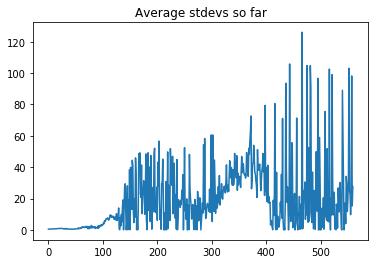

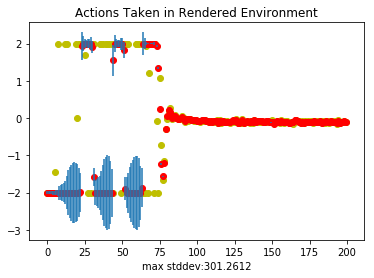

560
average reward:  -601.3400842145477 stdevs: 12.559629 losses: -0.19116159
561
average reward:  -534.6808779650061 stdevs: 18.94244 losses: 1.748537
562
average reward:  -613.9159103110502 stdevs: 31.530333 losses: 2.45859
563
average reward:  -558.5325421126142 stdevs: 59.109158 losses: 1.7800632
564
average reward:  -566.4618088850185 stdevs: 121.442116 losses: 2.2607532
565
average reward:  -466.0980834572062 stdevs: 6.8651223 losses: -0.5920717
566
average reward:  -580.2862248887482 stdevs: 12.458646 losses: -0.6510425
567
average reward:  -681.8131748317575 stdevs: 13.616994 losses: 0.4020797
568
average reward:  -690.2599847552399 stdevs: 29.114735 losses: 1.6186361
569
average reward:  -604.4348728059605 stdevs: 33.15252 losses: -0.4872392
570
average reward:  -529.8210845092605 stdevs: 46.483906 losses: 0.24807002
571
average reward:  -629.0492871450309 stdevs: 29.276093 losses: 3.5422587
572
average reward:  -504.5670628125166 stdevs: 21.139385 losses: 1.0031
573
average r

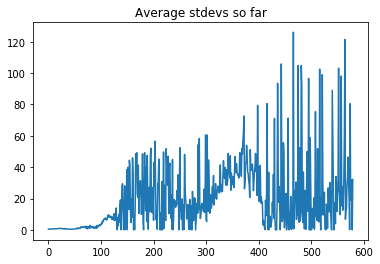

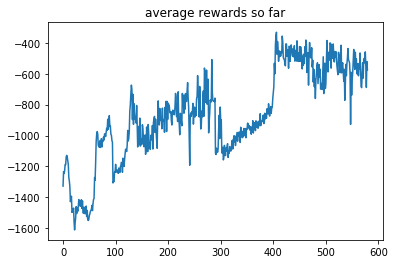

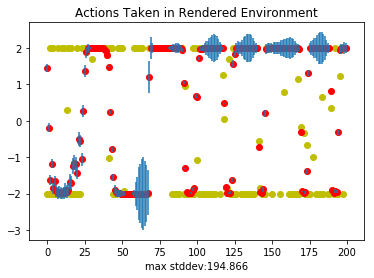

580
average reward:  -474.11968689929927 stdevs: 0.7271825 losses: 0.008571064
581
average reward:  -537.876841510108 stdevs: 16.531162 losses: -0.78090817
582
average reward:  -687.0349747178154 stdevs: 29.059374 losses: 2.1837013
583
average reward:  -437.8586822897096 stdevs: 15.890969 losses: -0.35610396
584
average reward:  -625.8935293622254 stdevs: 28.201649 losses: 2.2518077
585
average reward:  -536.5965330801206 stdevs: 9.117085 losses: -1.2390176
586
average reward:  -474.1531523812956 stdevs: 9.81445 losses: 0.103262626
587
average reward:  -568.1357762420023 stdevs: 29.364286 losses: 2.626466
588
average reward:  -671.9089404044984 stdevs: 26.89139 losses: 2.3400264
Saving the model after finding last 10 average rewards of: -558.819969681419
589
average reward:  -576.8887296786976 stdevs: 10.649316 losses: -1.1094348
590
average reward:  -563.6698712531884 stdevs: 21.490326 losses: 0.016961869
591
average reward:  -635.8463514956054 stdevs: 0.97124064 losses: -1.4447871
59

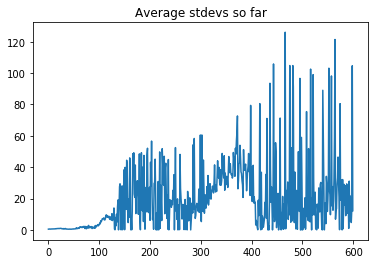

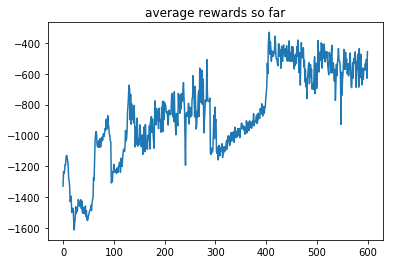

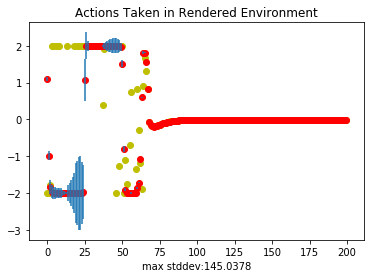

600
average reward:  -449.1614454160522 stdevs: 19.85637 losses: -0.4176178
601
average reward:  -531.6360320112827 stdevs: 8.394793 losses: -0.95466137
602
average reward:  -496.3079300991467 stdevs: 110.12014 losses: 1.2585953
603
average reward:  -478.5088954547329 stdevs: 18.166489 losses: 0.57447904
604
average reward:  -451.1232175215029 stdevs: 6.00812 losses: 0.20958234
605
average reward:  -542.4609467116609 stdevs: 33.684982 losses: 0.3559825
606
average reward:  -540.6791373758417 stdevs: 30.466747 losses: 2.8274405
607
average reward:  -462.58755009564754 stdevs: 35.686333 losses: 3.539224
608
average reward:  -349.4587119342451 stdevs: 68.86953 losses: 0.79171854
609
average reward:  -495.6098085296391 stdevs: 6.590519 losses: -0.27549222
610
average reward:  -451.79487010009905 stdevs: 0.8668299 losses: -0.43300557
611
average reward:  -500.13195765247093 stdevs: 12.077192 losses: -0.12339589
612
average reward:  -419.87513743286155 stdevs: 0.7497966 losses: -0.41465768
6

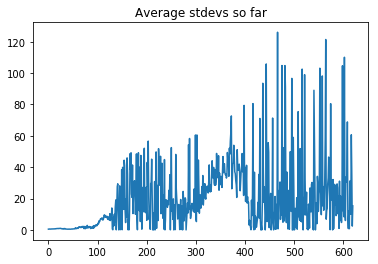

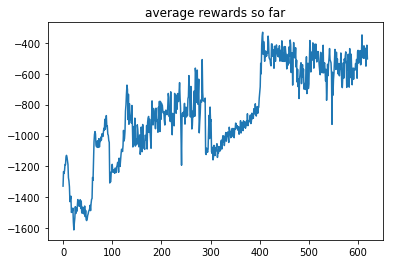

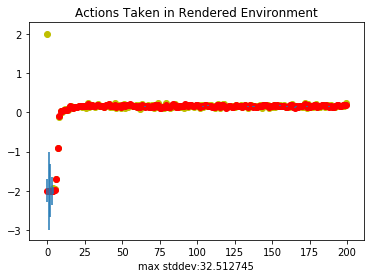

620
average reward:  -547.7577380935634 stdevs: 0.68473953 losses: -1.0577469
621
average reward:  -484.73724020725183 stdevs: 16.587471 losses: -0.20250428
622
average reward:  -497.72055207558725 stdevs: 15.438168 losses: -0.4991299
623
average reward:  -467.2989869971069 stdevs: 0.964718 losses: -0.5113037
624
average reward:  -548.8435994351997 stdevs: 31.757023 losses: 2.4289403
625
average reward:  -391.14569489919387 stdevs: 13.397871 losses: -0.65795743
626
average reward:  -475.0044841945366 stdevs: 127.17533 losses: 1.8564484
627
average reward:  -536.0721255985857 stdevs: 57.388393 losses: 0.26544997
628
average reward:  -496.6577687146699 stdevs: 5.258871 losses: -0.47460657
629
average reward:  -520.6742204438731 stdevs: 81.95775 losses: 0.5080518
630
average reward:  -585.3615939986715 stdevs: 17.178848 losses: -0.85572875
631
average reward:  -471.29709780968733 stdevs: 19.369741 losses: -0.7830984
632
average reward:  -449.4409621202367 stdevs: 15.822642 losses: -0.4240

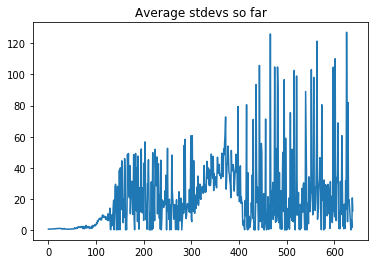

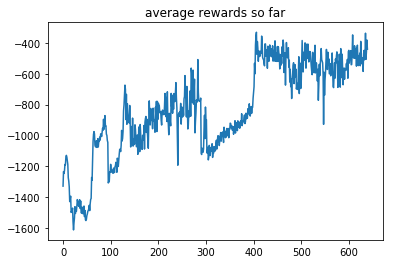

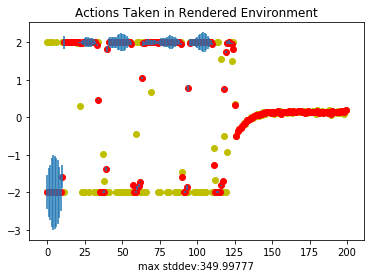

640
average reward:  -557.3038256333814 stdevs: 5.2441087 losses: -0.10008069
641
average reward:  -514.4487929518862 stdevs: 36.918995 losses: 1.5087284
642
average reward:  -488.61880738128184 stdevs: 62.878437 losses: 0.08015379
643
average reward:  -340.51095076437423 stdevs: 7.6961884 losses: -0.41283152
644
average reward:  -605.294824348743 stdevs: 62.611397 losses: 0.9705107
645
average reward:  -771.112484464702 stdevs: 99.0168 losses: 2.0491495
646
average reward:  -653.281496148132 stdevs: 45.04993 losses: -0.62847126
647
average reward:  -680.4990139558591 stdevs: 14.861033 losses: 0.275308
648
average reward:  -625.1804777257995 stdevs: 90.25282 losses: 0.38285658
649
average reward:  -584.9846124230671 stdevs: 20.227156 losses: -0.5613482
650
average reward:  -527.4308581871218 stdevs: 12.826913 losses: -0.27302328
651
average reward:  -546.500813150866 stdevs: 0.074818626 losses: -0.91806996
652
average reward:  -604.9166644520608 stdevs: 24.948835 losses: -0.10314845
65

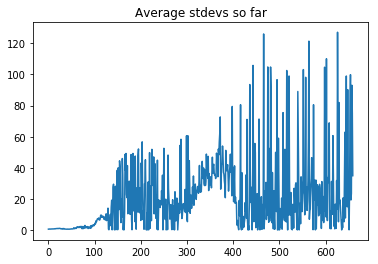

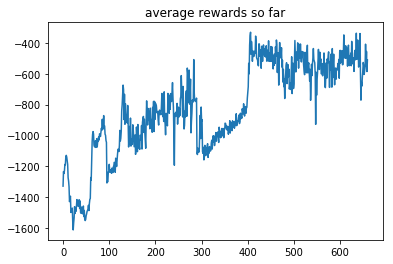

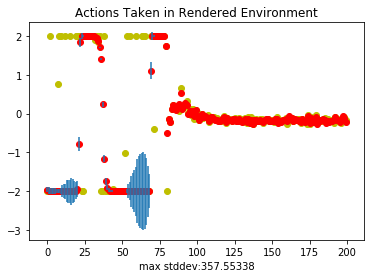

660
average reward:  -488.113347810031 stdevs: 97.84897 losses: 1.3226099
661
average reward:  -503.5094547766642 stdevs: 46.621758 losses: 0.6012536
662
average reward:  -541.0203852235676 stdevs: 120.16897 losses: 1.7915016
663
average reward:  -445.0708632911857 stdevs: 22.385881 losses: 0.594167
664
average reward:  -556.1002651348963 stdevs: 13.711119 losses: -0.9406738
665
average reward:  -549.3521834212027 stdevs: 58.90413 losses: 0.32088387
666
average reward:  -571.9539278736378 stdevs: 65.51562 losses: 0.71368855
667
average reward:  -565.2223778600238 stdevs: 17.733946 losses: -1.1125929
668
average reward:  -506.59462610423634 stdevs: 30.082357 losses: -0.34733072
669
average reward:  -407.3090350103154 stdevs: 21.286512 losses: -0.49560592
670
average reward:  -494.12813582672715 stdevs: 90.84898 losses: 1.4716327
671
average reward:  -396.27825584726054 stdevs: 21.336159 losses: -0.009578207
672
average reward:  -479.3908024693209 stdevs: 120.723854 losses: 1.1069934
673

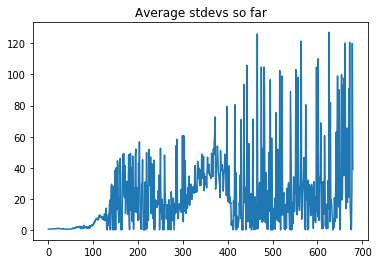

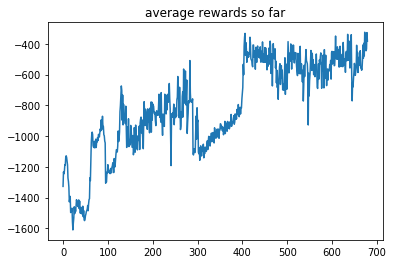

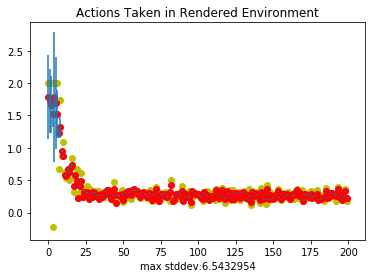

680
average reward:  -352.61245917248067 stdevs: 2.7551184 losses: 0.02349713
681
average reward:  -274.9362438776507 stdevs: 15.407521 losses: -0.10552818
682
average reward:  -333.96849228897406 stdevs: 3.3388457 losses: -1.4298314
683
average reward:  -390.97035685403114 stdevs: 13.209542 losses: -0.5642698
684
average reward:  -406.32662492629805 stdevs: 19.747627 losses: -0.31619292
685
average reward:  -423.15859090935874 stdevs: 24.015486 losses: 0.47950608
686
average reward:  -283.1445574351721 stdevs: 6.7813396 losses: 0.11330391
687
average reward:  -336.59104012123026 stdevs: 14.513166 losses: -0.28073844
688
average reward:  -392.2115286211046 stdevs: 7.971423 losses: 0.2835014
689
average reward:  -316.63933473401255 stdevs: 18.661621 losses: 1.1661398
690
average reward:  -421.20428192086894 stdevs: 15.839677 losses: -0.29922205
Saving the model after finding last 10 average rewards of: -357.9151051688701
691
average reward:  -351.7093516811083 stdevs: 3.2766018 losses: 

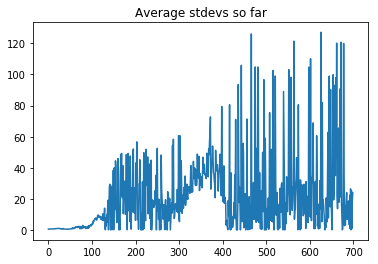

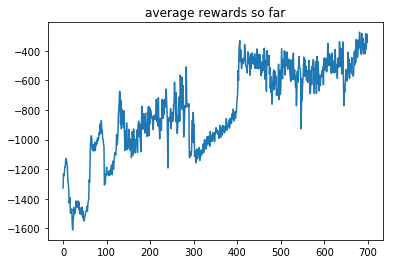

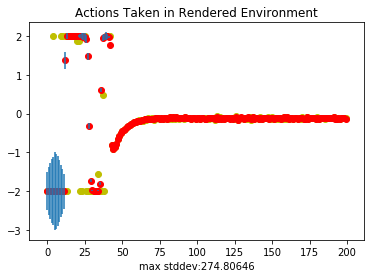

700
average reward:  -359.76983316535683 stdevs: 120.83631 losses: 2.3931904
701
average reward:  -416.3394396139912 stdevs: 42.04302 losses: 2.4795277
702
average reward:  -346.54676146853353 stdevs: 21.517868 losses: 0.17102271
703
average reward:  -360.4237856787539 stdevs: 19.039467 losses: -0.116267554
704
average reward:  -366.6412844998519 stdevs: 8.610381 losses: 0.56336987
705
average reward:  -294.16041137688643 stdevs: 33.042244 losses: 1.4243249
706
average reward:  -324.94363578292456 stdevs: 31.81292 losses: 1.1659544
707
average reward:  -269.0532347568146 stdevs: 2.6839828 losses: -0.0030536533
708
average reward:  -379.32569217037224 stdevs: 23.066082 losses: -0.09389875
709
average reward:  -374.7745445987983 stdevs: 0.7761445 losses: -0.71181935
710
average reward:  -411.6101961364393 stdevs: 15.260254 losses: 0.09995264
711
average reward:  -464.98273341643716 stdevs: 23.895351 losses: 0.42226794
712
average reward:  -532.6834620697739 stdevs: 31.633745 losses: 0.54

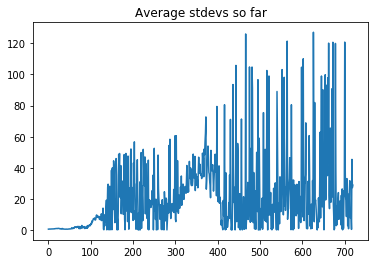

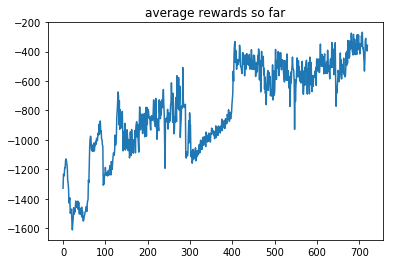

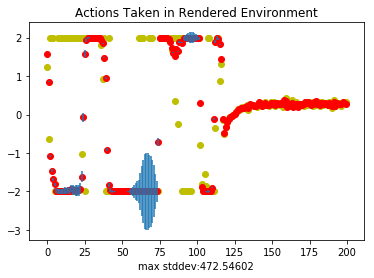

720
average reward:  -417.89545531157444 stdevs: 24.815865 losses: 0.2964263
721
average reward:  -361.02173126205537 stdevs: 19.464466 losses: -0.82041717
722
average reward:  -398.10889238111486 stdevs: 21.74311 losses: -0.59543264
723
average reward:  -415.7252691721818 stdevs: 17.747967 losses: -0.3709931
724
average reward:  -452.9424964020494 stdevs: 19.43967 losses: -0.5719863
725
average reward:  -393.34302815640217 stdevs: 55.390533 losses: 2.7489338
726
average reward:  -394.4048386937531 stdevs: 140.49986 losses: 1.587444
727
average reward:  -422.581593609407 stdevs: 1.2329602 losses: -0.39199978
728
average reward:  -373.4631039974855 stdevs: 22.633781 losses: -0.57925594
729
average reward:  -370.432774436671 stdevs: 21.233652 losses: -0.23504785
730
average reward:  -426.4024231403288 stdevs: 13.648839 losses: 1.2552122
731
average reward:  -526.293633477944 stdevs: 37.759735 losses: 0.25726014
732
average reward:  -350.218360896023 stdevs: 94.06475 losses: 0.87386256
73

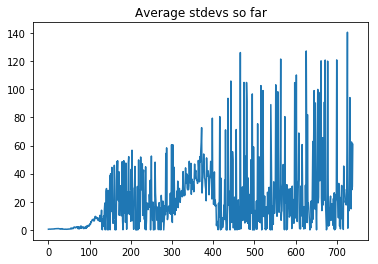

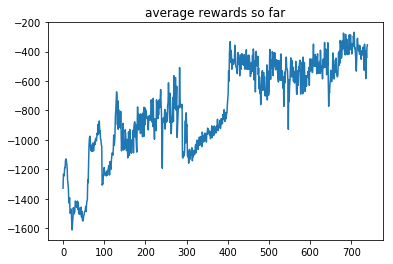

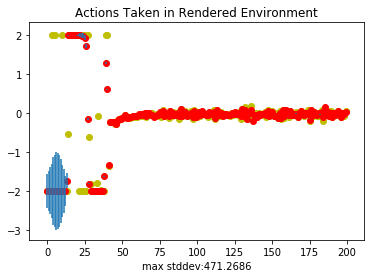

740
average reward:  -439.64891364596514 stdevs: 37.530697 losses: -0.2913072
741
average reward:  -363.1568967530096 stdevs: 39.567772 losses: -0.33389822
Saving the model after finding last 10 average rewards of: -411.17648328731394
742
average reward:  -366.06851242259165 stdevs: 7.685759 losses: 0.253338
743
average reward:  -410.4556669014857 stdevs: 30.534742 losses: 0.60071844
744
average reward:  -336.1785342600184 stdevs: 92.324814 losses: 0.49525523
745
average reward:  -460.91172270952455 stdevs: 41.934685 losses: 1.5832121
746
average reward:  -391.42041095796577 stdevs: 66.24561 losses: 0.43761164
747
average reward:  -333.1365865162712 stdevs: 0.7102004 losses: -0.5455747
748
average reward:  -365.77322926001506 stdevs: 54.01459 losses: 2.6243896
749
average reward:  -369.3843865028516 stdevs: 25.031054 losses: -0.17297556
750
average reward:  -715.6954181588438 stdevs: 104.61689 losses: 0.44787115
751
average reward:  -654.2329681896902 stdevs: 83.75932 losses: 0.0089130

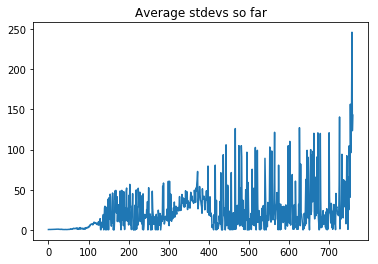

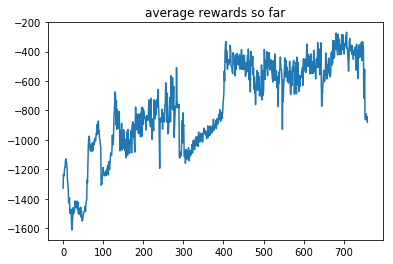

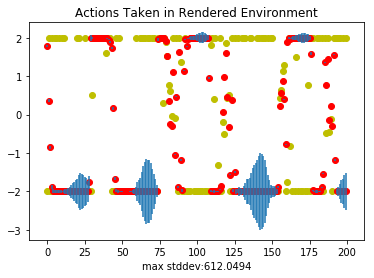

760
average reward:  -884.5682125192834 stdevs: 152.74536 losses: -0.71187675
761
average reward:  -832.967462088216 stdevs: 79.12829 losses: 0.8218667
762
average reward:  -817.7231042116964 stdevs: 124.07838 losses: 0.27342212
763
average reward:  -835.6921596075666 stdevs: 153.0571 losses: 0.20259278
764
average reward:  -853.8858753401182 stdevs: 103.76142 losses: 0.04098779
765
average reward:  -852.7555044868243 stdevs: 129.43217 losses: 0.33548915
766
average reward:  -859.8874701274035 stdevs: 153.28986 losses: -0.3164227
767
average reward:  -791.0202292492611 stdevs: 155.15858 losses: 0.91510475
768
average reward:  -863.1719074415902 stdevs: 175.82707 losses: 0.31411013
769
average reward:  -818.7433936194138 stdevs: 153.92714 losses: -0.005438225
770
average reward:  -854.5100022560821 stdevs: 101.187874 losses: -0.30651382
771
average reward:  -781.7588485341488 stdevs: 159.83948 losses: -0.4267367
772
average reward:  -774.3793581259857 stdevs: 111.69288 losses: 0.6584954

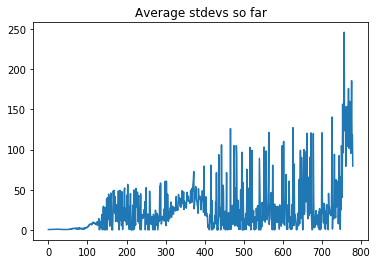

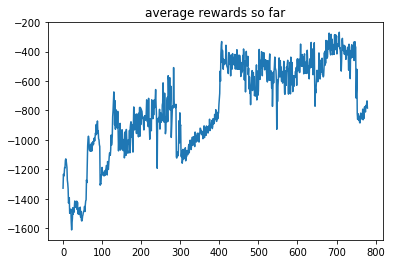

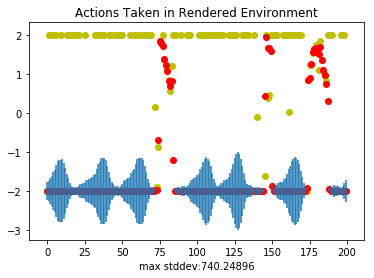

780
average reward:  -820.8905014240388 stdevs: 155.08226 losses: -0.30630997
781
average reward:  -819.3570648430948 stdevs: 47.61924 losses: 1.7504011
782
average reward:  -848.7926893239726 stdevs: 64.35956 losses: -0.05315936
783
average reward:  -841.415643422956 stdevs: 182.56454 losses: 1.0216486
784
average reward:  -747.7024433991776 stdevs: 155.27794 losses: 0.054970652
785
average reward:  -713.3188815768424 stdevs: 114.26117 losses: -1.193847
786
average reward:  -726.31001562933 stdevs: 105.34132 losses: 0.050914392
787
average reward:  -719.3556924239007 stdevs: 156.68738 losses: -0.22840467
788
average reward:  -672.554861298899 stdevs: 86.176674 losses: -1.0918742
789
average reward:  -766.371289911376 stdevs: 128.44495 losses: 0.24838787
790
average reward:  -708.399116448916 stdevs: 150.50021 losses: -0.38181275
791
average reward:  -733.6686076970617 stdevs: 187.70999 losses: 0.6286858
792
average reward:  -789.2240705418372 stdevs: 59.456306 losses: 1.8859284
Saving

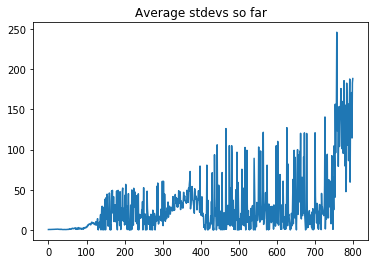

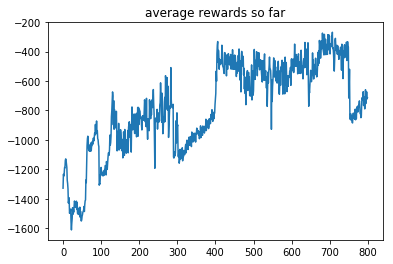

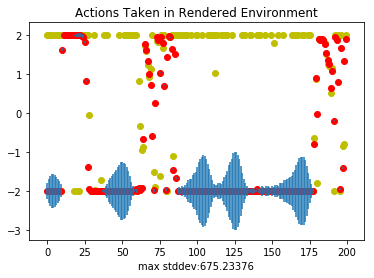

800
average reward:  -683.6065559704557 stdevs: 76.12289 losses: -1.2852715
801
average reward:  -683.3702832197556 stdevs: 129.66342 losses: -0.022666883
802
average reward:  -661.279742321158 stdevs: 52.777374 losses: -1.1270815
803
average reward:  -657.231235218166 stdevs: 128.0752 losses: -0.59599847
804
average reward:  -605.6911491412617 stdevs: 95.0097 losses: -0.9306396
805
average reward:  -572.3096340773523 stdevs: 95.54147 losses: -0.37750563
806
average reward:  -528.6985489196684 stdevs: 103.09499 losses: -0.7334229
807
average reward:  -540.375600365441 stdevs: 66.02314 losses: -1.0979788
808
average reward:  -355.75638387976846 stdevs: 130.60217 losses: 1.0115302
809
average reward:  -350.57486196206173 stdevs: 38.224895 losses: -0.23276351
810
average reward:  -344.3610879994011 stdevs: 37.389465 losses: -0.5823682
811
average reward:  -315.0585756709807 stdevs: 40.231327 losses: -0.75532717
812
average reward:  -427.8184904558184 stdevs: 1.8136959 losses: -0.6427269
8

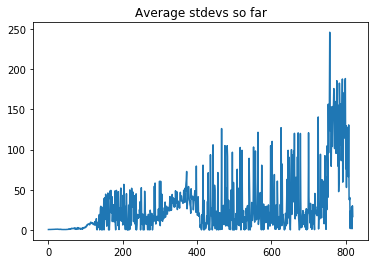

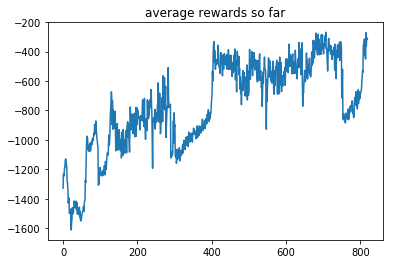

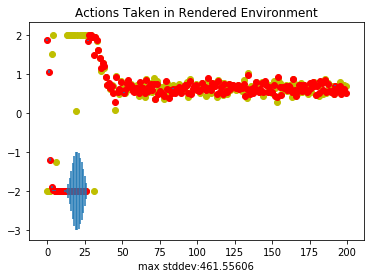

820
average reward:  -376.59388570398903 stdevs: 29.79755 losses: 0.18147138
821
average reward:  -301.6259093758416 stdevs: 2.2162657 losses: -0.005663751
822
average reward:  -410.41079401137966 stdevs: 17.850794 losses: -0.41752222
823
average reward:  -365.6209503195963 stdevs: 0.08575213 losses: -0.16897522
824
average reward:  -357.0039376460631 stdevs: 37.60053 losses: 0.54482836
825
average reward:  -346.296306604131 stdevs: 2.7718456 losses: 0.13558252
826
average reward:  -383.94505509690214 stdevs: 14.56094 losses: -0.7817742
827
average reward:  -288.5999818573852 stdevs: 30.832973 losses: -0.5354847
828
average reward:  -362.0889180057452 stdevs: 138.0858 losses: 1.5264838
829
average reward:  -270.92145046991044 stdevs: 0.082098365 losses: 0.047212917
830
average reward:  -339.9547645446587 stdevs: 31.886173 losses: -0.3086512
831
average reward:  -344.11778025417345 stdevs: 15.562355 losses: -0.4321817
832
average reward:  -245.34681085774758 stdevs: 1.6729249 losses: -0

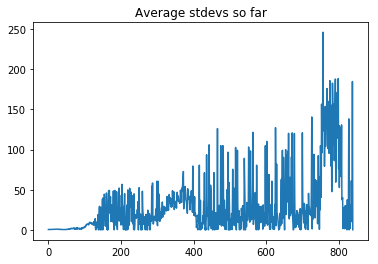

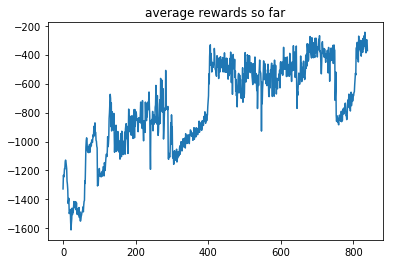

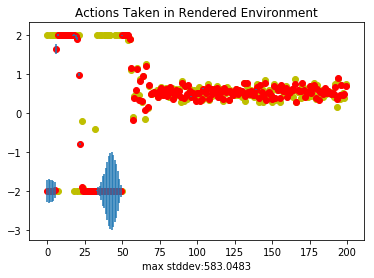

840
average reward:  -314.83583338972693 stdevs: 23.639849 losses: -0.22269478
841
average reward:  -400.1641485007346 stdevs: 2.3386676 losses: -0.2195652
842
average reward:  -333.63576383973566 stdevs: 0.6369549 losses: -0.45703536
843
average reward:  -245.43421939396595 stdevs: 65.88672 losses: 0.31874666
Saving the model after finding last 10 average rewards of: -324.56213356449786
844
average reward:  -334.95454775593646 stdevs: 1.0856801 losses: -0.23526421
845
average reward:  -274.94482684023876 stdevs: 70.11329 losses: 0.52911747
846
average reward:  -263.9527873307469 stdevs: 2.788923 losses: 0.28174052
847
average reward:  -263.6940430505242 stdevs: 31.79871 losses: -0.2897538
848
average reward:  -308.67683194126846 stdevs: 0.621804 losses: -0.3915191
849
average reward:  -259.48609624805897 stdevs: 9.325819 losses: -0.4469922
850
average reward:  -357.79426578880145 stdevs: 70.3106 losses: 0.4534927
851
average reward:  -758.7051913303868 stdevs: 219.86237 losses: 1.6029

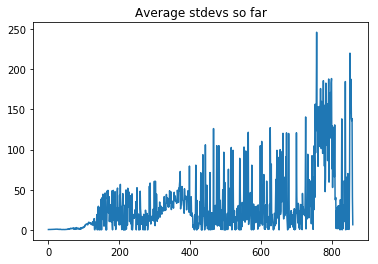

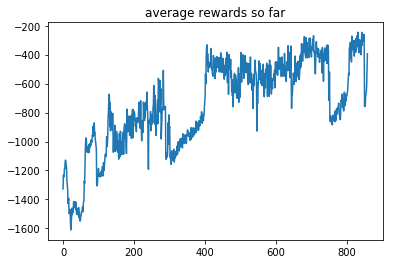

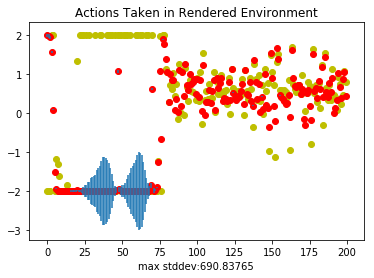

860
average reward:  -354.5346182368245 stdevs: 38.35345 losses: -0.53185827
861
average reward:  -363.6554350909575 stdevs: 28.400406 losses: -0.850212
862
average reward:  -328.60384887487754 stdevs: 66.19254 losses: 0.3222224
863
average reward:  -301.8406469977439 stdevs: 33.493607 losses: -1.0252007
864
average reward:  -297.18119713657387 stdevs: 13.741164 losses: -0.78622174
865
average reward:  -328.4601269501572 stdevs: 33.172733 losses: 0.21681094
866
average reward:  -336.01034260732325 stdevs: 18.37723 losses: -0.49248374
867
average reward:  -361.4063460588635 stdevs: 2.519713 losses: -0.2841769
868
average reward:  -303.9395812789924 stdevs: 9.979703 losses: -0.6599473
869
average reward:  -310.68885489488537 stdevs: 27.28981 losses: -0.40029383
870
average reward:  -266.1621475347556 stdevs: 2.9610734 losses: 0.25365117
871
average reward:  -238.934272021832 stdevs: 6.317927 losses: -0.78715307
872
average reward:  -258.6192458441536 stdevs: 1.981284 losses: -0.004350462

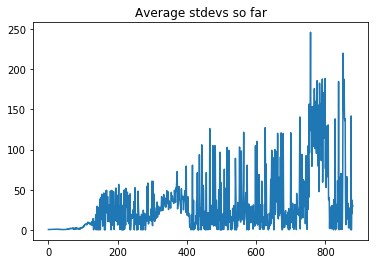

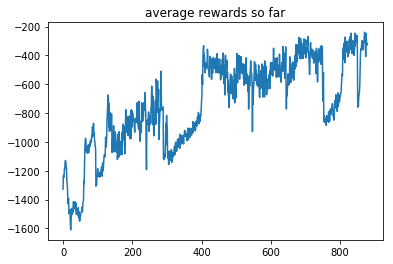

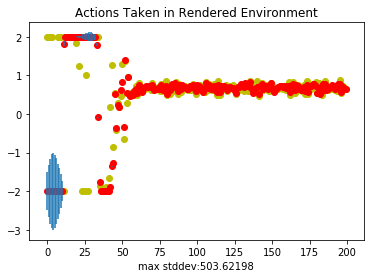

880
average reward:  -301.3400181548242 stdevs: 28.437794 losses: 0.27881306
881
average reward:  -290.9164332905572 stdevs: 0.04197571 losses: 0.02584706
882
average reward:  -268.85999827280557 stdevs: 66.96822 losses: 0.4231479
883
average reward:  -346.1921453664019 stdevs: 144.30281 losses: 1.4671943
884
average reward:  -288.5551165935452 stdevs: 24.638245 losses: -0.12024314
885
average reward:  -304.13202053578914 stdevs: 74.06703 losses: 0.3445381
886
average reward:  -297.65127517795287 stdevs: 26.54105 losses: -0.49701288
887
average reward:  -285.1693172383408 stdevs: 40.122032 losses: 0.20763278
888
average reward:  -362.2418004992818 stdevs: 27.457401 losses: 0.8565819
889
average reward:  -321.1884951593762 stdevs: 34.93578 losses: 0.7050912
890
average reward:  -294.74220079319997 stdevs: 27.279026 losses: -0.22069621
891
average reward:  -302.88932252248156 stdevs: 63.92984 losses: 0.21827917
892
average reward:  -298.32735105072607 stdevs: 32.49288 losses: -0.26732793

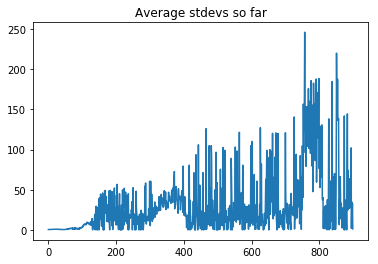

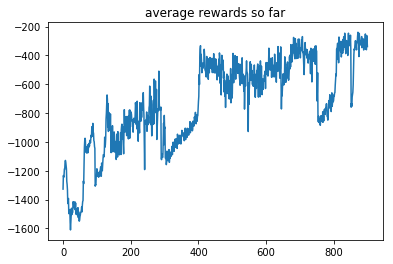

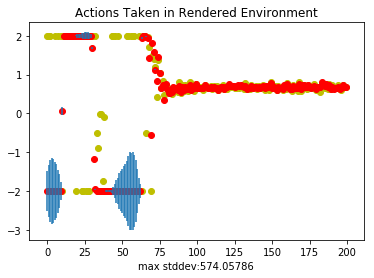

900
average reward:  -292.95369707777894 stdevs: 2.3910353 losses: -0.26858553
901
average reward:  -333.718165759562 stdevs: 30.802486 losses: 0.02412955
902
average reward:  -261.04303927689494 stdevs: 17.123344 losses: -0.06840939
903
average reward:  -307.049888005562 stdevs: 20.054781 losses: -0.088650726
904
average reward:  -294.0013401607107 stdevs: 1.9864987 losses: -0.16568556
905
average reward:  -250.6287280430106 stdevs: 3.711629 losses: 0.32637188
906
average reward:  -266.84949301074835 stdevs: 2.814085 losses: -0.048671167
907
average reward:  -303.17111727830826 stdevs: 0.5052741 losses: -0.40130243
908
average reward:  -241.21697230177915 stdevs: 29.623297 losses: -0.30919647
909
average reward:  -319.3202269764347 stdevs: 0.7229936 losses: -0.20989403
910
average reward:  -279.4483144916928 stdevs: 1.1412075 losses: -0.09238256
911
average reward:  -314.7014435226441 stdevs: 17.348875 losses: -0.09026283
912
average reward:  -319.11463001702396 stdevs: 23.811106 loss

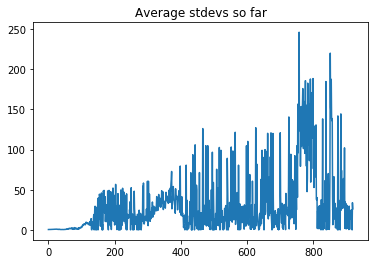

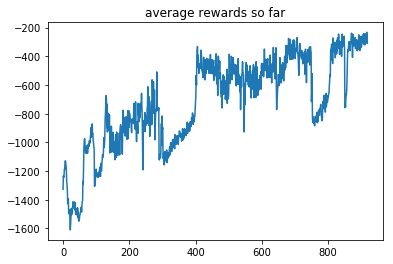

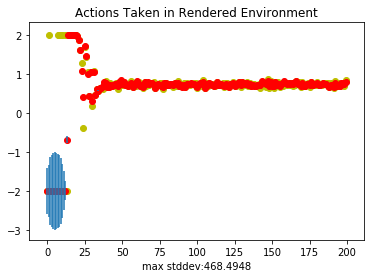

920
average reward:  -304.3733981852971 stdevs: 5.8138213 losses: 0.20071343
921
average reward:  -295.1808858993542 stdevs: 17.19005 losses: -0.04987688
922
average reward:  -294.58163226435414 stdevs: 2.9077768 losses: 0.124335706
923
average reward:  -242.71551664601824 stdevs: 20.082706 losses: 0.105413996
924
average reward:  -270.0421527982896 stdevs: 2.0646527 losses: -1.0480471
925
average reward:  -248.4928951042391 stdevs: 0.7269677 losses: -0.123445734
926
average reward:  -279.96039338742196 stdevs: 7.115546 losses: -0.26367238
927
average reward:  -304.342556135495 stdevs: 1.4889153 losses: -0.14612123
928
average reward:  -284.9471644107736 stdevs: 25.082342 losses: -0.0307978
929
average reward:  -313.640020773815 stdevs: 1.0468459 losses: -0.06671432
930
average reward:  -440.59152343259984 stdevs: 164.59619 losses: 1.289062
931
average reward:  -363.12965567729344 stdevs: 116.00497 losses: 0.27719736
932
average reward:  -363.13709946232166 stdevs: 26.757753 losses: -0

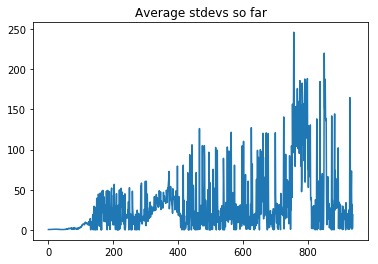

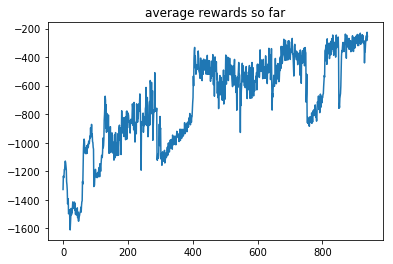

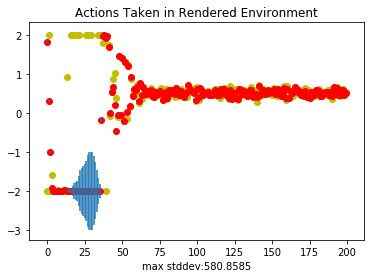

940
average reward:  -268.6763970614976 stdevs: 27.291447 losses: 0.1978371
941
average reward:  -256.64746175001414 stdevs: 33.05865 losses: -0.24969006
942
average reward:  -322.7520008568569 stdevs: 177.86514 losses: 1.3844702
943
average reward:  -237.29505630213066 stdevs: 35.20768 losses: -0.029234575
944
average reward:  -274.99296716363267 stdevs: 28.173458 losses: 0.29134205
945
average reward:  -240.95793500874433 stdevs: 35.61128 losses: -0.36629558
Saving the model after finding last 10 average rewards of: -261.7262401903862
946
average reward:  -266.30106314755267 stdevs: 34.901955 losses: 0.12357454
947
average reward:  -258.28342833801725 stdevs: 27.208418 losses: -0.4164932
948
average reward:  -266.07607112106706 stdevs: 0.20140389 losses: -0.40326345
949
average reward:  -261.32118508356876 stdevs: 0.056228273 losses: 0.020253038
950
average reward:  -221.6437898366142 stdevs: 21.777115 losses: -0.26351088
951
average reward:  -259.2213185220071 stdevs: 29.582178 loss

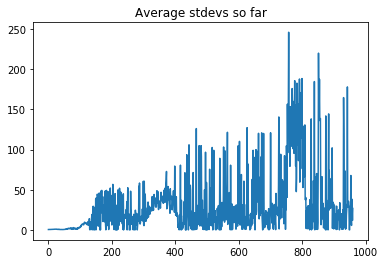

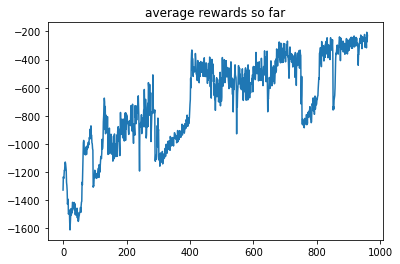

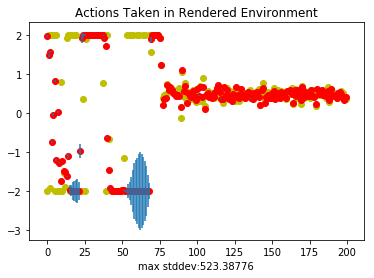

960
average reward:  -264.01993868814793 stdevs: 24.009525 losses: -0.065949515
961
average reward:  -229.52828275727316 stdevs: 70.591515 losses: 0.059644733
962
average reward:  -237.32301086149477 stdevs: 32.709476 losses: 0.10167459
963
average reward:  -215.6744355516079 stdevs: 24.363918 losses: -0.12619588
964
average reward:  -247.39616380537328 stdevs: 25.003626 losses: -0.15761837
965
average reward:  -256.62177720087345 stdevs: 28.58862 losses: -0.21311195
966
average reward:  -228.3359557507938 stdevs: 26.73549 losses: 0.05317281
967
average reward:  -277.1064951936616 stdevs: 26.847878 losses: -0.2974728
968
average reward:  -224.98495217694426 stdevs: 63.69273 losses: 0.2902305
969
average reward:  -304.476520130556 stdevs: 1.6855652 losses: -0.20220543
970
average reward:  -223.93639422730143 stdevs: 34.83468 losses: 0.5027593
971
average reward:  -245.1738466699835 stdevs: 18.65655 losses: 0.03402202
972
average reward:  -289.281841521845 stdevs: 23.710896 losses: -0.37

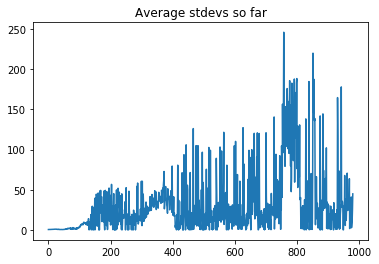

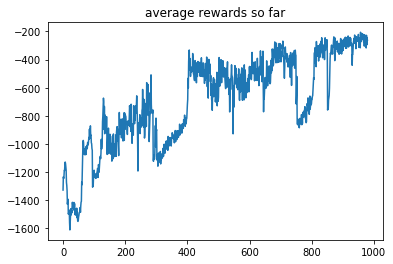

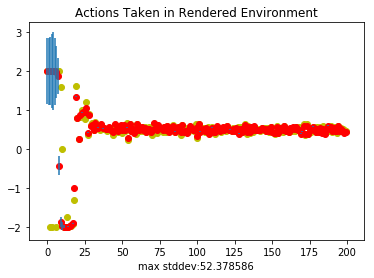

980
average reward:  -276.43543084059445 stdevs: 0.08116713 losses: -0.01064966
981
average reward:  -229.8043296126551 stdevs: 2.71035 losses: -0.18875074
982
average reward:  -257.91312451716175 stdevs: 108.88215 losses: 1.4286237
983
average reward:  -224.45511321532635 stdevs: 5.964077 losses: -0.40742657
984
average reward:  -248.73677461134412 stdevs: 1.6328171 losses: -0.15472324
985
average reward:  -306.00785457759514 stdevs: 0.09709777 losses: -0.1509056
986
average reward:  -304.005872119406 stdevs: 20.796663 losses: 0.13499828
987
average reward:  -268.75584708020006 stdevs: 28.259981 losses: 0.10449798
988
average reward:  -317.27397814024755 stdevs: 26.185656 losses: -0.4693511
989
average reward:  -281.41861836382833 stdevs: 38.4 losses: -0.2561255
990
average reward:  -240.53570193200753 stdevs: 0.30884305 losses: -0.2922502
991
average reward:  -276.88452317362754 stdevs: 1.2445338 losses: 0.073238626
992
average reward:  -286.0577096052915 stdevs: 64.968895 losses: 0.

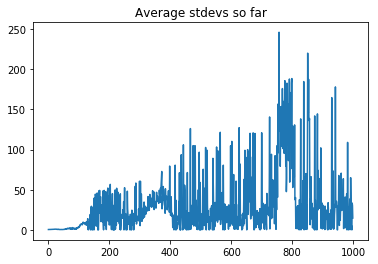

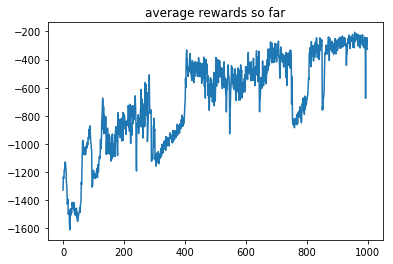

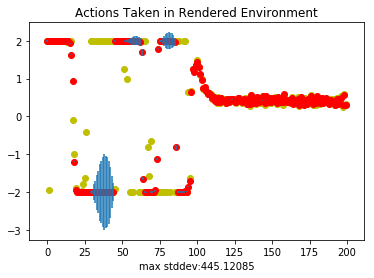

1000
average reward:  -249.58316815050958 stdevs: 22.33928 losses: -0.35031727
1001
average reward:  -280.23582062039185 stdevs: 2.5340116 losses: -0.49770796
1002
average reward:  -244.02887069959115 stdevs: 32.612804 losses: -0.17458315
1003
average reward:  -301.72642416995274 stdevs: 17.291111 losses: -0.39714476
1004
average reward:  -250.15977903395046 stdevs: 0.04776831 losses: 0.03058167
1005
average reward:  -315.7128577528382 stdevs: 23.977785 losses: -0.3519562
1006
average reward:  -199.41763406777667 stdevs: 1.5840433 losses: -0.27185014
1007
average reward:  -284.4516710077227 stdevs: 24.190723 losses: -0.34519693
1008
average reward:  -274.47385418924625 stdevs: 3.4125338 losses: -0.04659923
1009
average reward:  -302.4480638558958 stdevs: 20.321125 losses: -0.34648076
1010
average reward:  -247.62135812188598 stdevs: 22.031118 losses: -0.49280682
1011
average reward:  -222.20730703733972 stdevs: 21.404245 losses: -0.055260748
1012
average reward:  -278.99287673568335 st

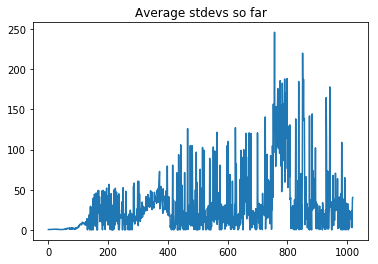

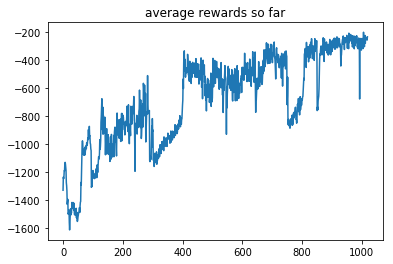

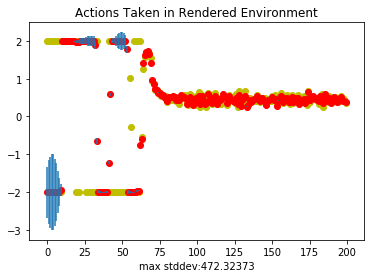

1020
average reward:  -266.7836702859119 stdevs: 31.254177 losses: 0.17547052
1021
average reward:  -256.06548885567247 stdevs: 5.0707817 losses: -0.36082035
1022
average reward:  -236.1056676852194 stdevs: 7.0515666 losses: 0.26958776
1023
average reward:  -210.25486462877228 stdevs: 30.71475 losses: 0.07322348
1024
average reward:  -243.37714486038794 stdevs: 73.9103 losses: 0.8234302
1025
average reward:  -214.87612254258315 stdevs: 3.8648112 losses: -0.06689594
1026
average reward:  -278.0854313524642 stdevs: 34.698807 losses: 0.10480959
1027
average reward:  -257.1229284261115 stdevs: 10.399482 losses: 0.34572697
1028
average reward:  -204.7794471177587 stdevs: 1.6153212 losses: -0.12698331
1029
average reward:  -263.97180025027194 stdevs: 3.1535845 losses: -0.42092878
1030
average reward:  -230.73649726087461 stdevs: 15.211618 losses: 0.21701418
1031
average reward:  -237.6204145459984 stdevs: 1.5573386 losses: -0.522533
1032
average reward:  -243.34866883938557 stdevs: 3.1203208

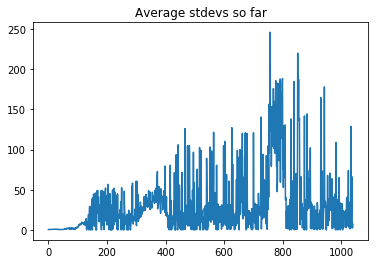

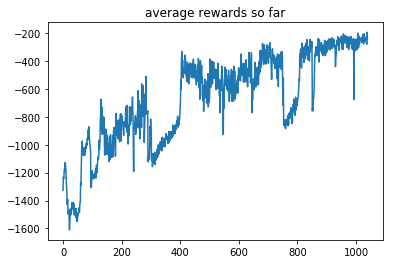

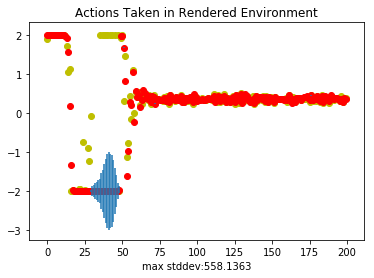

1040
average reward:  -215.31286736589215 stdevs: 3.606244 losses: 0.054779895
1041
average reward:  -232.2980727105009 stdevs: 12.086988 losses: 0.09714659
1042
average reward:  -220.1658454897909 stdevs: 32.830547 losses: 0.08666028
1043
average reward:  -189.2653616077997 stdevs: 31.921644 losses: -0.4042151
1044
average reward:  -210.13271204309953 stdevs: 24.455244 losses: -0.28273872
1045
average reward:  -248.97938202402725 stdevs: 26.197319 losses: 0.2756521
1046
average reward:  -210.50744466164915 stdevs: 25.410507 losses: 0.06840403
1047
average reward:  -255.17935915796724 stdevs: 6.8959546 losses: -0.11450312
Saving the model after finding last 10 average rewards of: -222.00075351163247
1048
average reward:  -241.10959557010256 stdevs: 105.23915 losses: 1.1689156
1049
average reward:  -223.57810771979356 stdevs: 9.380291 losses: 0.21559182
1050
average reward:  -198.13020076884268 stdevs: 3.8336103 losses: 0.2938214
1051
average reward:  -584.2952019364742 stdevs: 94.90328

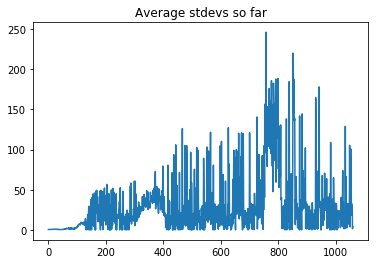

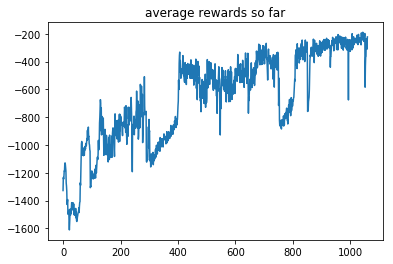

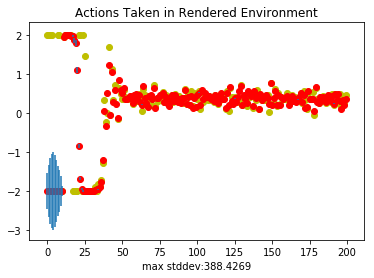

1060
average reward:  -296.6990757854319 stdevs: 3.511863 losses: -0.42413744
1061
average reward:  -267.8206856906331 stdevs: 26.584291 losses: -0.3176986
1062
average reward:  -289.8488442882207 stdevs: 2.5040302 losses: -0.2848461
1063
average reward:  -249.6835758309222 stdevs: 1.4616529 losses: -0.21248788
1064
average reward:  -287.5183831521775 stdevs: 24.717062 losses: 0.21253546
1065
average reward:  -330.78153281250735 stdevs: 99.78926 losses: 0.8822621
1066
average reward:  -270.99361302204414 stdevs: 20.482758 losses: 0.054641973
1067
average reward:  -281.67085599068264 stdevs: 34.259537 losses: -0.3658829
1068
average reward:  -255.14990364716488 stdevs: 23.657906 losses: -0.17553036
1069
average reward:  -257.58792191164247 stdevs: 24.895226 losses: 0.32592028
1070
average reward:  -266.47070861149246 stdevs: 35.687157 losses: 0.071087755
1071
average reward:  -216.61322260086672 stdevs: 6.6347313 losses: 0.39599395
1072
average reward:  -207.86952823800198 stdevs: 46.99

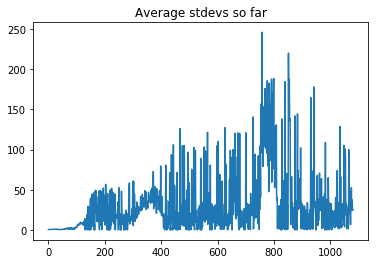

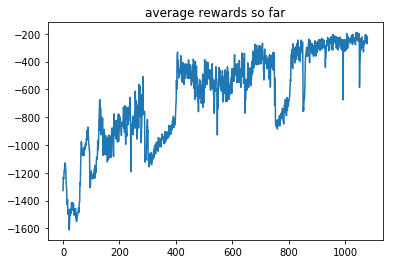

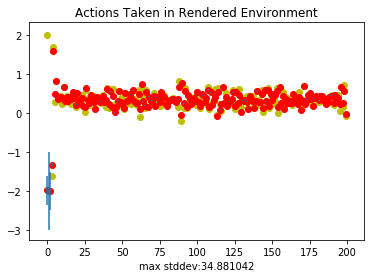

1080
average reward:  -239.54440472188145 stdevs: 10.07616 losses: 0.1588653
1081
average reward:  -219.59338044691495 stdevs: 56.419273 losses: 0.33757728
1082
average reward:  -218.88023376769925 stdevs: 14.779729 losses: 0.2384333
1083
average reward:  -210.93101619521758 stdevs: 8.035451 losses: -0.020463433
1084
average reward:  -240.12689902501992 stdevs: 1.9629887 losses: -0.08633855
1085
average reward:  -255.36587966990146 stdevs: 0.80085427 losses: -0.1361605
1086
average reward:  -243.67610641415885 stdevs: 23.881002 losses: 0.5303974
1087
average reward:  -255.82964618035606 stdevs: 6.8621397 losses: 0.26846805
1088
average reward:  -228.33567345047405 stdevs: 20.114384 losses: 0.05261425
1089
average reward:  -216.57873381709152 stdevs: 0.1281254 losses: 0.076072164
1090
average reward:  -503.1007205005044 stdevs: 101.84113 losses: 0.14825171
1091
average reward:  -300.4869715513323 stdevs: 23.263716 losses: -0.4215206
1092
average reward:  -256.38041436491983 stdevs: 69.4

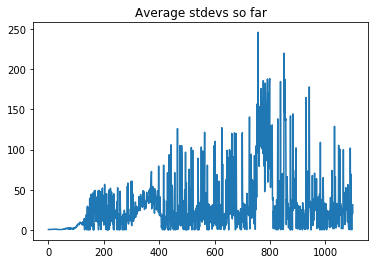

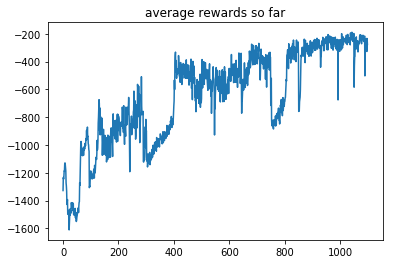

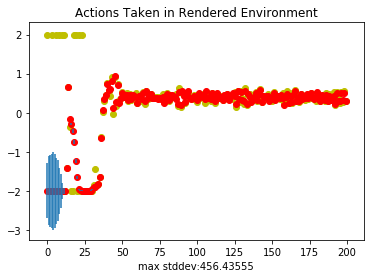

1100
average reward:  -358.8660835874365 stdevs: 1.4267186 losses: -0.23893352
1101
average reward:  -305.2779726804207 stdevs: 27.643192 losses: 0.05056624
1102
average reward:  -365.15522917402706 stdevs: 31.861338 losses: 0.29358852
1103
average reward:  -271.47493866690746 stdevs: 76.04419 losses: 0.5515077
1104
average reward:  -290.2767070579837 stdevs: 1.6369168 losses: -0.13952968
1105
average reward:  -277.9440879018304 stdevs: 1.9656783 losses: -0.3267593
1106
average reward:  -282.2440093256622 stdevs: 17.67174 losses: 0.32932413
1107
average reward:  -320.0150374231831 stdevs: 3.0524344 losses: 0.14979029
1108
average reward:  -349.2715354520245 stdevs: 43.37634 losses: 1.0460838
1109
average reward:  -435.393332346672 stdevs: 3.704578 losses: -0.17239064
1110
average reward:  -364.2769640936061 stdevs: 0.45676762 losses: -0.5188296
1111
average reward:  -348.40061775435953 stdevs: 25.82535 losses: 0.3442836
1112
average reward:  -349.10405536881206 stdevs: 23.41974 losses:

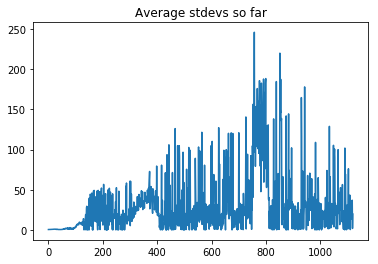

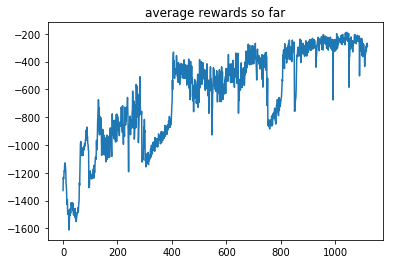

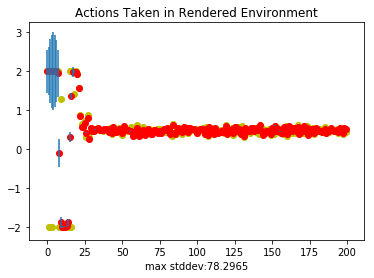

1120
average reward:  -344.58057905858425 stdevs: 30.656096 losses: 1.0330255
1121
average reward:  -300.53870433625724 stdevs: 7.1793833 losses: 0.40477788
1122
average reward:  -400.36044669327936 stdevs: 31.0956 losses: -0.8084235
1123
average reward:  -296.5629481882765 stdevs: 3.2106957 losses: -0.24627277
1124
average reward:  -231.81506031858711 stdevs: 0.932697 losses: -0.1395959
1125
average reward:  -393.5258361494265 stdevs: 34.831635 losses: 0.25367042
1126
average reward:  -429.0374291362965 stdevs: 64.83381 losses: -0.58348894
1127
average reward:  -370.8493713526076 stdevs: 0.5001732 losses: -0.2835866
1128
average reward:  -396.970574123017 stdevs: 1.0299765 losses: -0.4682253
1129
average reward:  -368.5529830347197 stdevs: 0.30983752 losses: -0.44543126
1130
average reward:  -336.50618026795144 stdevs: 36.366 losses: -0.30089894
1131
average reward:  -383.6164253861613 stdevs: 85.091736 losses: -0.102809496
1132
average reward:  -410.6532108268972 stdevs: 25.141165 lo

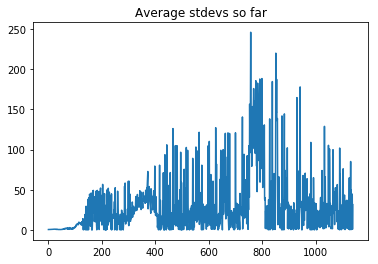

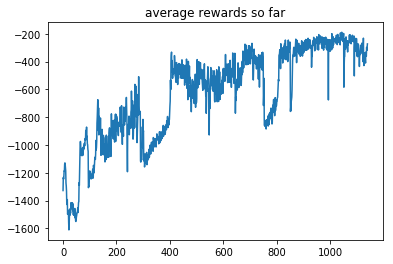

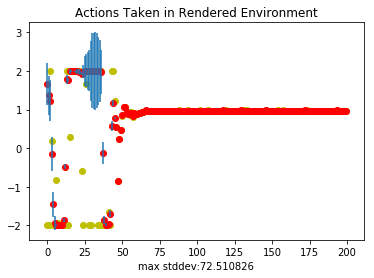

1140
average reward:  -308.8777909177032 stdevs: 8.4360485 losses: 1.0101373
1141
average reward:  -345.36138512537184 stdevs: 16.577526 losses: 0.011416769
1142
average reward:  -308.8193787944303 stdevs: 28.556215 losses: 1.1884255
1143
average reward:  -304.58001750990104 stdevs: 1.6262609 losses: -0.042988654
1144
average reward:  -339.2539291437721 stdevs: 41.79557 losses: -0.06386172
1145
average reward:  -315.5252428771639 stdevs: 44.37708 losses: 0.28985754
1146
average reward:  -264.56583457919777 stdevs: 35.420963 losses: -0.19464694
1147
average reward:  -347.20343754619404 stdevs: 24.424274 losses: 0.07443883
1148
average reward:  -340.4975200898021 stdevs: 24.25298 losses: -0.33588767
1149
average reward:  -352.26867827783735 stdevs: 14.074989 losses: -0.55114037
Saving the model after finding last 10 average rewards of: -322.69532148613735
1150
average reward:  -375.6924539502046 stdevs: 34.760586 losses: -0.060861778
1151
average reward:  -265.3017089195981 stdevs: 50.06

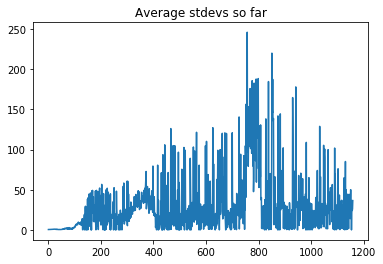

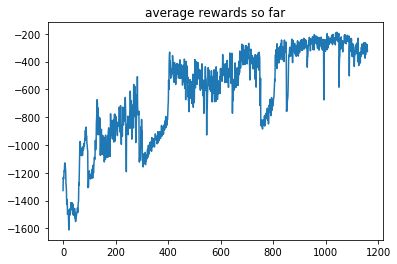

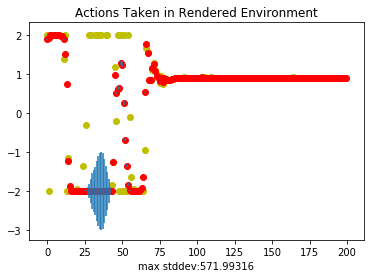

1160
average reward:  -335.64783712038934 stdevs: 70.79838 losses: -0.20432796
1161
average reward:  -336.3935349247452 stdevs: 12.8195915 losses: 1.5020629
1162
average reward:  -294.07772324431846 stdevs: 23.783827 losses: -0.08601067
1163
average reward:  -367.08495689240624 stdevs: 18.05978 losses: -0.2532282
1164
average reward:  -424.90335754354436 stdevs: 51.002625 losses: 2.3122776
1165
average reward:  -313.65437593893796 stdevs: 45.003082 losses: 1.234814
1166
average reward:  -376.7973111836245 stdevs: 44.696953 losses: 0.62560576
1167
average reward:  -310.45189832455725 stdevs: 0.37419045 losses: -0.24133669
1168
average reward:  -315.8936839258461 stdevs: 0.6132952 losses: 0.01805079
1169
average reward:  -308.1269202495124 stdevs: 81.84831 losses: -0.11672019
1170
average reward:  -333.178539615057 stdevs: 18.425747 losses: -0.3183695
1171
average reward:  -303.15137771172584 stdevs: 46.003666 losses: 0.24254936
1172
average reward:  -351.329145082587 stdevs: 19.596254 l

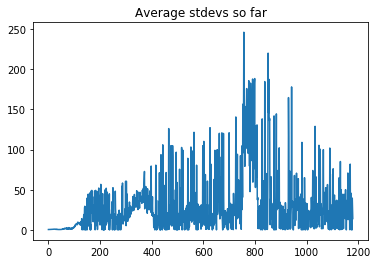

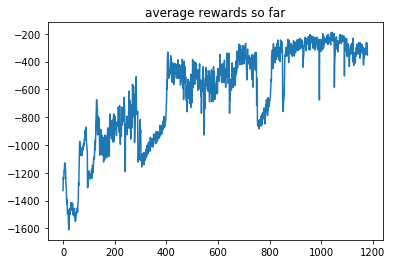

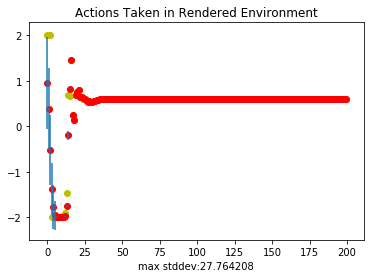

1180
average reward:  -360.05103096749247 stdevs: 0.089678384 losses: -0.23112172
1181
average reward:  -323.2669053108769 stdevs: 0.0003142963 losses: 0.014529023
1182
average reward:  -315.1766234006187 stdevs: 2.9699578 losses: 0.29104406
1183
average reward:  -317.3252522758704 stdevs: 41.145775 losses: -0.34729072
1184
average reward:  -348.423055805396 stdevs: 0.0010128578 losses: -0.05876894
1185
average reward:  -354.39328280887304 stdevs: 127.3703 losses: 1.3720975
1186
average reward:  -275.938751755985 stdevs: 23.35545 losses: 0.31820253
1187
average reward:  -414.2885693254384 stdevs: 80.44844 losses: -0.5140858
1188
average reward:  -447.7736423506041 stdevs: 33.153423 losses: 0.35992858
1189
average reward:  -471.3762626477348 stdevs: 23.158854 losses: -0.41471437
1190
average reward:  -348.71027673709597 stdevs: 41.415363 losses: 0.06497801
1191
average reward:  -446.71044782751886 stdevs: 29.373087 losses: -0.16609071
1192
average reward:  -369.0504091714489 stdevs: 26.

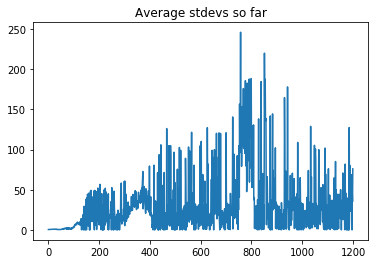

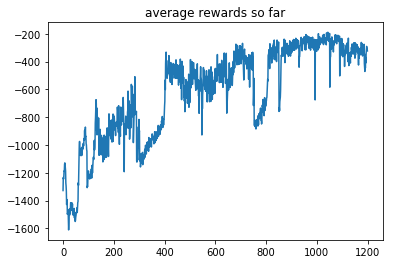

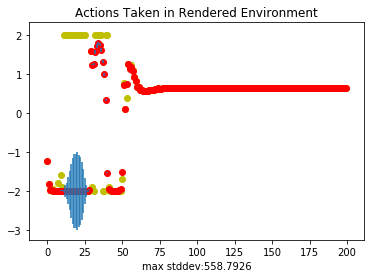

1200
average reward:  -309.9356613017041 stdevs: 6.0760384 losses: 0.47649947
Saving the model after finding last 10 average rewards of: -341.7130381540767
1201
average reward:  -298.2254224422014 stdevs: 31.647692 losses: 0.109357536
1202
average reward:  -353.6391069434218 stdevs: 19.558893 losses: -0.10234023
1203
average reward:  -251.02482749304045 stdevs: 19.70936 losses: 0.21904078
1204
average reward:  -320.9829006776185 stdevs: 18.550705 losses: 0.7232401
1205
average reward:  -388.86801580919075 stdevs: 3.150588 losses: -0.23085955
1206
average reward:  -384.4624503484025 stdevs: 3.1395202 losses: -0.26252243
1207
average reward:  -417.0355741583282 stdevs: 1.2937236 losses: -0.35845518
1208
average reward:  -378.847213165625 stdevs: 114.08512 losses: 1.0932586
1209
average reward:  -342.8185500099531 stdevs: 12.561939 losses: -0.40143612
1210
average reward:  -358.89704018087787 stdevs: 20.652441 losses: -0.37659088
1211
average reward:  -367.0352124425111 stdevs: 22.613428 

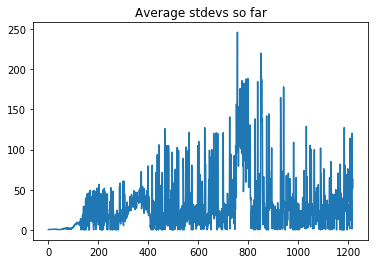

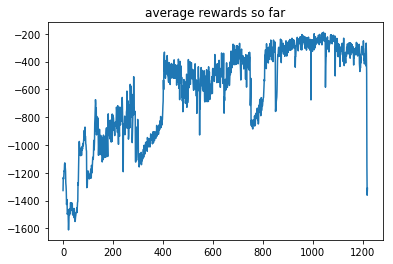

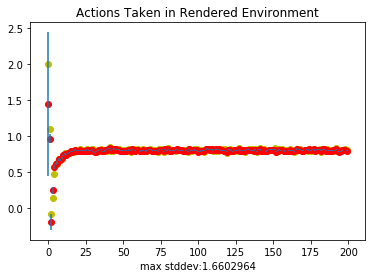

1220
average reward:  -1226.7160697350942 stdevs: 0.008603196 losses: 0.056783307
1221
average reward:  -1308.1418932818517 stdevs: 45.25106 losses: 1.3509457
1222
average reward:  -1397.1844254189195 stdevs: 135.71265 losses: 1.977151
1223
average reward:  -1281.129275511224 stdevs: 106.525986 losses: 1.620828
1224
average reward:  -1431.2936951855686 stdevs: 57.802925 losses: 0.6476395
1225
average reward:  -1460.560580252999 stdevs: 24.679996 losses: 0.5561465
1226
average reward:  -1451.6171126062277 stdevs: 44.44746 losses: 0.8728504
1227
average reward:  -1448.8030126631197 stdevs: 39.75776 losses: 1.237121
1228
average reward:  -1375.0928130492312 stdevs: 26.759518 losses: 1.6412288
1229
average reward:  -1286.3713240640423 stdevs: 36.188816 losses: 1.9525455
1230
average reward:  -896.1318547612957 stdevs: 55.452614 losses: 1.4056834
1231
average reward:  -1271.4418976910688 stdevs: 57.843525 losses: 1.3650696
1232
average reward:  -1343.7287293516465 stdevs: 57.191048 losses: 

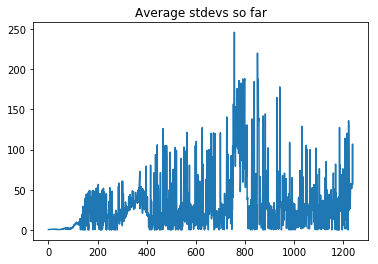

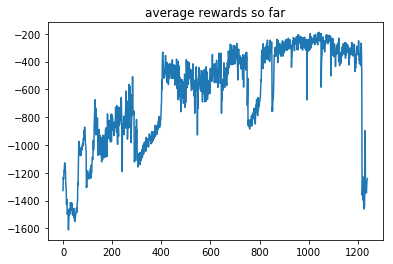

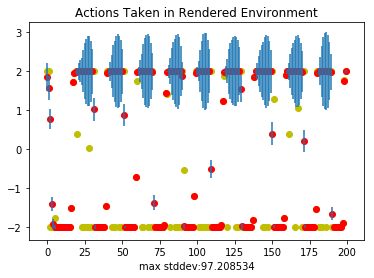

1240
average reward:  -1127.8778850765768 stdevs: 135.84319 losses: 0.1610675
1241
average reward:  -1136.8569482219993 stdevs: 32.711872 losses: -4.714025
1242
average reward:  -1090.0792134757137 stdevs: 48.585564 losses: 1.9381125
1243
average reward:  -1302.0047097511379 stdevs: 64.56985 losses: 0.023884362
1244
average reward:  -1225.7303356253517 stdevs: 32.693825 losses: 0.5431565
1245
average reward:  -1122.3844032252478 stdevs: 33.933044 losses: 1.6013769
1246
average reward:  -1047.3191866176173 stdevs: 51.491028 losses: 1.5344572
1247
average reward:  -998.5611788610837 stdevs: 81.75043 losses: 1.6529894
1248
average reward:  -1311.7432754979857 stdevs: 98.55343 losses: 0.73893917
1249
average reward:  -1167.3079294090053 stdevs: 59.27042 losses: 1.007881
1250
average reward:  -1129.6118211708276 stdevs: 81.60601 losses: -3.000635
1251
average reward:  -1292.9000182320106 stdevs: 33.960663 losses: 0.5141215
1252
average reward:  -1249.7554742699535 stdevs: 58.155476 losses: 

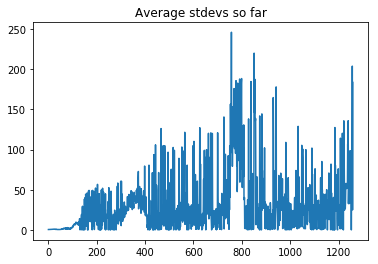

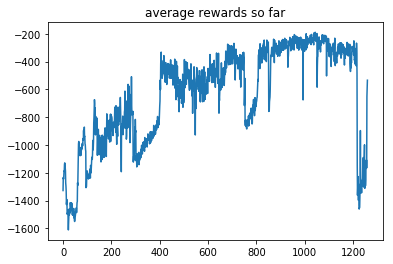

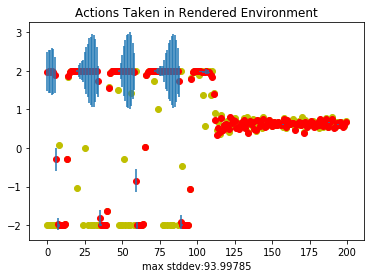

1260
average reward:  -530.7101841070815 stdevs: 69.86918 losses: -1.4930892
1261
average reward:  -565.3791848087942 stdevs: 113.031876 losses: -0.4420139
Saving the model after finding last 10 average rewards of: -868.9055472790985
1262
average reward:  -503.73593885983047 stdevs: 49.60332 losses: -2.1904502
1263
average reward:  -521.4501589576766 stdevs: 27.073605 losses: -1.7797375
1264
average reward:  -492.55222312801726 stdevs: 42.677963 losses: -1.425503
1265
average reward:  -488.3257487429495 stdevs: 87.308945 losses: 0.21307154
1266
average reward:  -327.2662871532712 stdevs: 41.551884 losses: -0.5452977
1267
average reward:  -359.61084465602306 stdevs: 0.9670635 losses: -0.8697003
1268
average reward:  -342.63912135325285 stdevs: 53.9624 losses: -0.6018242
1269
average reward:  -442.97260929764764 stdevs: 7.289324 losses: 0.19451025
1270
average reward:  -410.0479906442192 stdevs: 26.934006 losses: -0.8611978
1271
average reward:  -367.12138467318835 stdevs: 43.033916 loss

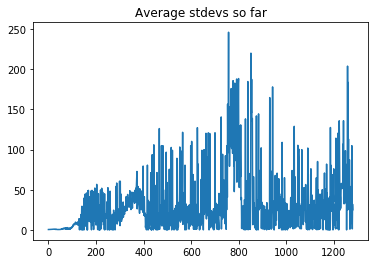

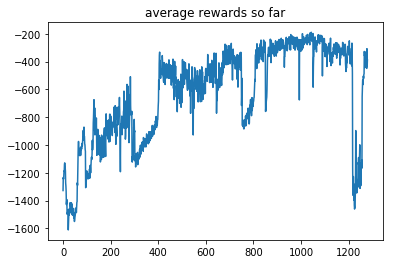

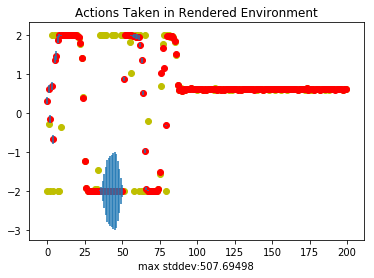

1280
average reward:  -338.688910932272 stdevs: 31.86408 losses: -0.39901096
1281
average reward:  -316.465065899201 stdevs: 3.307865 losses: -0.2874582
1282
average reward:  -379.1111749793214 stdevs: 4.5392785 losses: 0.07216952
1283
average reward:  -336.93886225446266 stdevs: 37.730095 losses: -0.29053307
1284
average reward:  -346.0986255922664 stdevs: 36.38883 losses: 0.016634049
1285
average reward:  -334.18354921507256 stdevs: 15.594966 losses: -0.44769678
1286
average reward:  -308.61111204627423 stdevs: 0.5483802 losses: -0.3093423
1287
average reward:  -392.5015783870514 stdevs: 0.9372307 losses: -0.3998815
1288
average reward:  -341.80428640354864 stdevs: 0.7110641 losses: -0.3777273
1289
average reward:  -395.27622607816005 stdevs: 27.314102 losses: -0.18458505
1290
average reward:  -346.7255784360591 stdevs: 0.0041894102 losses: 0.00088112167
1291
average reward:  -292.8423085151052 stdevs: 26.40575 losses: -0.11457847
1292
average reward:  -391.6634585976286 stdevs: 58.7

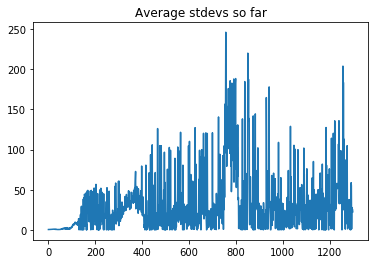

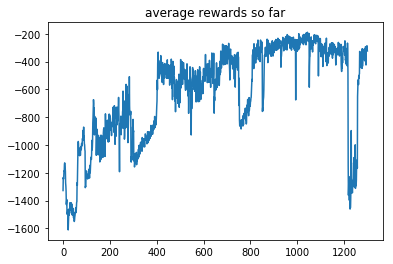

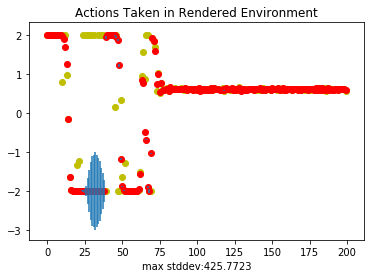

1300
average reward:  -280.7909574322511 stdevs: 28.32888 losses: 0.2911503
1301
average reward:  -308.9276009857455 stdevs: 134.18736 losses: 0.36951634
1302
average reward:  -305.9212637597951 stdevs: 1.1652762 losses: -0.22586533
1303
average reward:  -273.2581056517625 stdevs: 35.790318 losses: -0.7907896
1304
average reward:  -331.33969155064926 stdevs: 1.0264091 losses: -0.5503784
1305
average reward:  -328.08996959461285 stdevs: 47.322166 losses: 0.17814188
1306
average reward:  -351.76410016182564 stdevs: 15.474233 losses: -0.33417916
1307
average reward:  -250.06425836041882 stdevs: 1.146421 losses: -0.2942425
1308
average reward:  -355.54853525676043 stdevs: 18.561062 losses: -0.33539912
1309
average reward:  -277.9342270337146 stdevs: 3.0933516 losses: -0.10913085
1310
average reward:  -270.98320813038555 stdevs: 28.672499 losses: -0.105566226
1311
average reward:  -269.90012742237167 stdevs: 8.218302 losses: -0.52563334
1312
average reward:  -322.11356435324376 stdevs: 2.15

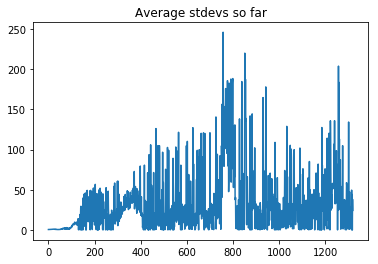

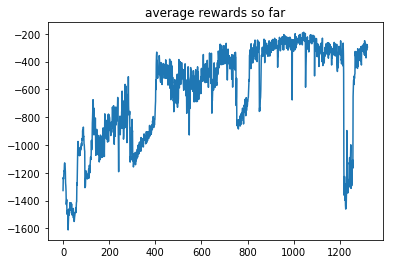

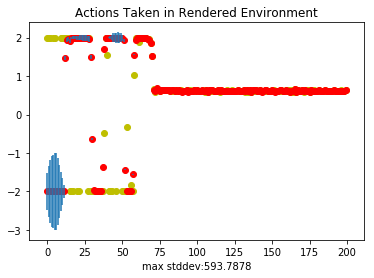

1320
average reward:  -279.6417779343112 stdevs: 126.29716 losses: 0.46960032
1321
average reward:  -290.99653495420955 stdevs: 19.558825 losses: -0.045992166
1322
average reward:  -358.0808746130547 stdevs: 21.537075 losses: -0.1305385
1323
average reward:  -302.6761180391941 stdevs: 91.35513 losses: 0.86556256
1324
average reward:  -259.4343488390672 stdevs: 203.83784 losses: 1.0125697
1325
average reward:  -354.0986721457788 stdevs: 2.6639204 losses: -0.012589814
1326
average reward:  -338.17639173925863 stdevs: 32.117657 losses: -0.102167554
1327
average reward:  -368.8713423639732 stdevs: 39.567833 losses: -0.009173379
1328
average reward:  -288.23918881940347 stdevs: 4.191173 losses: 0.27923757
1329
average reward:  -335.9372602464955 stdevs: 21.986078 losses: -0.25549144
1330
average reward:  -330.80886593441954 stdevs: 9.735905 losses: 1.1229786
1331
average reward:  -274.9211669905524 stdevs: 34.879078 losses: -0.2524165
1332
average reward:  -354.29686506621204 stdevs: 1.5115

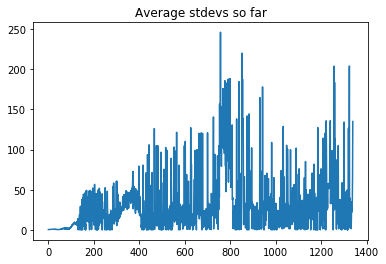

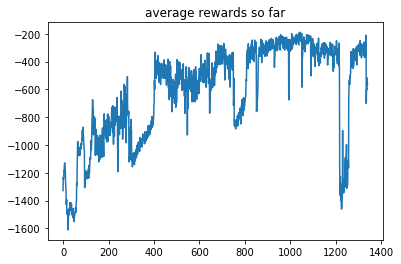

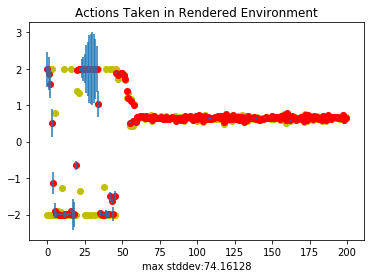

1340
average reward:  -532.9259522082841 stdevs: 3.4297526 losses: -0.61170596
1341
average reward:  -412.3531888514435 stdevs: 27.606274 losses: -0.25306755
1342
average reward:  -426.72171689997083 stdevs: 1.3513933 losses: -0.8838653
1343
average reward:  -443.29553106550554 stdevs: 27.153414 losses: -0.7096965
1344
average reward:  -383.5144621706415 stdevs: 46.000065 losses: -0.51202637
1345
average reward:  -367.5565964197788 stdevs: 14.863576 losses: -0.65849537
1346
average reward:  -373.2662815793509 stdevs: 94.7871 losses: 0.2603307
1347
average reward:  -356.486616168568 stdevs: 38.33809 losses: 0.10253053
1348
average reward:  -330.2859450416196 stdevs: 42.343994 losses: 0.25486225
1349
average reward:  -296.23264681269615 stdevs: 86.005936 losses: 0.11485571
1350
average reward:  -322.0221613784888 stdevs: 2.4304645 losses: -0.23432466
1351
average reward:  -319.5854921034248 stdevs: 9.453128 losses: 1.4286907
1352
average reward:  -362.7001603255447 stdevs: 38.586033 loss

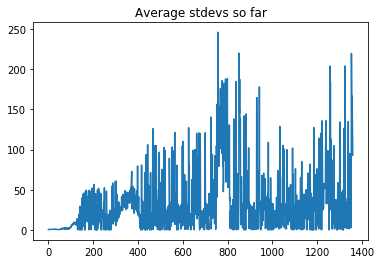

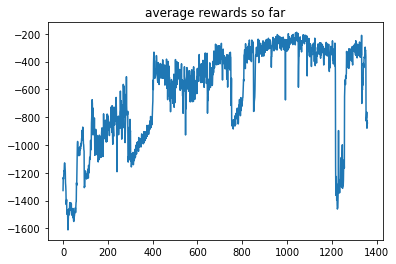

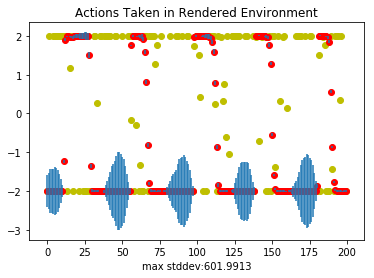

1360
average reward:  -829.0304344703221 stdevs: 154.24678 losses: 0.32920572
1361
average reward:  -820.5686406459012 stdevs: 191.13846 losses: 1.137654
1362
average reward:  -660.0179307497116 stdevs: 74.40086 losses: -0.17215776
1363
average reward:  -664.1338132883536 stdevs: 37.530327 losses: -1.5469353
Saving the model after finding last 10 average rewards of: -789.5463495136432
1364
average reward:  -522.5986360859508 stdevs: 102.97766 losses: -0.30399844
1365
average reward:  -529.1798468799082 stdevs: 17.80542 losses: -1.0332273
1366
average reward:  -500.44128952955816 stdevs: 68.44181 losses: 0.12846234
1367
average reward:  -479.85517356708215 stdevs: 6.8749986 losses: -0.5001039
1368
average reward:  -529.9719713961496 stdevs: 71.50616 losses: -0.6285471
1369
average reward:  -561.0487715880363 stdevs: 98.30157 losses: 0.56128573
1370
average reward:  -478.7928513622727 stdevs: 149.60262 losses: 1.3431028
1371
average reward:  -263.7631403479803 stdevs: 63.95832 losses: -0

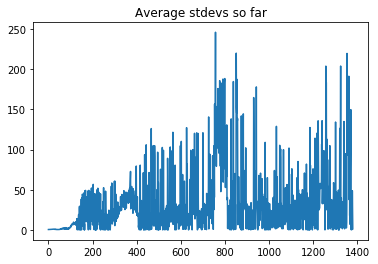

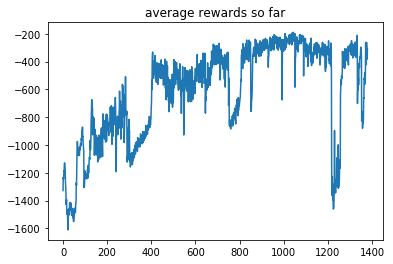

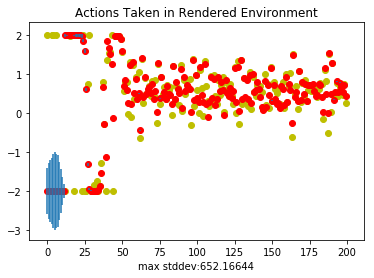

1380
average reward:  -377.3850976552429 stdevs: 143.75945 losses: 1.1072489
1381
average reward:  -535.9504623487442 stdevs: 103.92376 losses: 1.1289722
1382
average reward:  -633.4489357361242 stdevs: 39.454086 losses: -0.4499236
1383
average reward:  -731.6445990547127 stdevs: 229.10081 losses: 2.3195639
1384
average reward:  -783.0738668491877 stdevs: 93.91523 losses: -0.13194534
1385
average reward:  -720.4405187380843 stdevs: 106.66324 losses: -0.06189264
1386
average reward:  -920.5254931311865 stdevs: 171.54086 losses: -0.14148419
1387
average reward:  -867.3520511704803 stdevs: 193.33429 losses: 0.53966767
1388
average reward:  -707.9253128507163 stdevs: 93.46169 losses: 0.6906912
1389
average reward:  -801.7126633881095 stdevs: 77.290115 losses: 1.4553481
1390
average reward:  -833.7096966681927 stdevs: 101.065605 losses: -0.21295282
1391
average reward:  -831.0653990817679 stdevs: 78.78594 losses: -1.2204494
1392
average reward:  -680.5941195402374 stdevs: 45.312275 losses: 

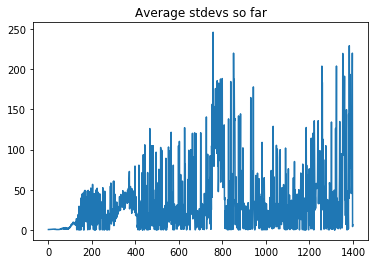

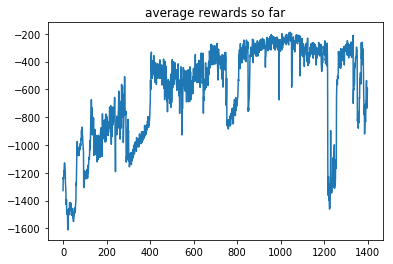

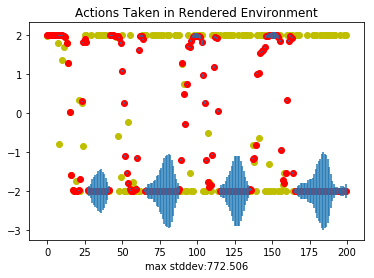

1400
average reward:  -494.3572638811518 stdevs: 200.1746 losses: 1.9730814
1401
average reward:  -642.7336258113842 stdevs: 129.35687 losses: 1.6968175
1402
average reward:  -751.8711054920419 stdevs: 25.409893 losses: -1.2770709
1403
average reward:  -850.2487187115654 stdevs: 4.1412683 losses: -1.1320007
1404
average reward:  -782.9941630424152 stdevs: 241.28104 losses: 1.6348522
1405
average reward:  -856.7404553571229 stdevs: 86.87663 losses: 1.0528065
1406
average reward:  -812.9137740896856 stdevs: 207.47287 losses: 1.532326
1407
average reward:  -863.5472787481307 stdevs: 120.14699 losses: 0.4506677
1408
average reward:  -868.1284330677327 stdevs: 257.15692 losses: 1.3241
1409
average reward:  -895.112663177677 stdevs: 101.080635 losses: -0.49655473
1410
average reward:  -908.475596965173 stdevs: 105.25642 losses: 0.36247346
1411
average reward:  -916.2757666061341 stdevs: 69.59304 losses: -0.879454
1412
average reward:  -1018.5700439575692 stdevs: 321.09076 losses: 1.3592793
1

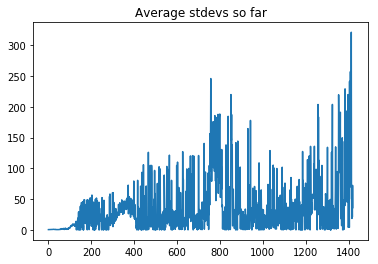

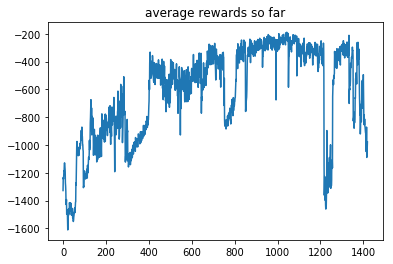

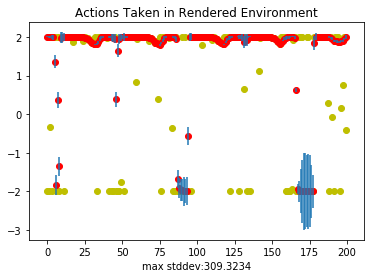

1420
average reward:  -970.3411813843479 stdevs: 40.5821 losses: -2.5297582
1421
average reward:  -914.4823377655633 stdevs: 150.95683 losses: 0.81377715
1422
average reward:  -838.4158510995287 stdevs: 118.49678 losses: 0.6831383
1423
average reward:  -927.2670872468454 stdevs: 154.58574 losses: -0.093081295
1424
average reward:  -963.4748354074602 stdevs: 133.72093 losses: -1.3534263
1425
average reward:  -902.5426183995241 stdevs: 0.039324984 losses: -1.0338417
1426
average reward:  -847.0098867721235 stdevs: 119.83817 losses: 0.53382653
1427
average reward:  -943.8228732351133 stdevs: 135.41644 losses: -0.48525894
1428
average reward:  -847.7783959742694 stdevs: 2.5447624 losses: -1.9916244
1429
average reward:  -831.07302891487 stdevs: 0.03396655 losses: -0.719
Saving the model after finding last 10 average rewards of: -898.6208096199646
1430
average reward:  -755.2951979810713 stdevs: 141.76529 losses: -0.4748818
1431
average reward:  -855.2353003832374 stdevs: 1.7221154 losses: 

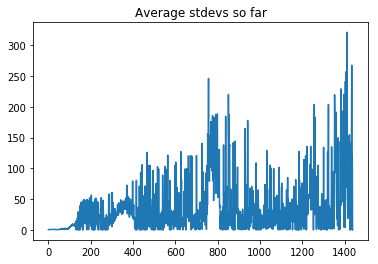

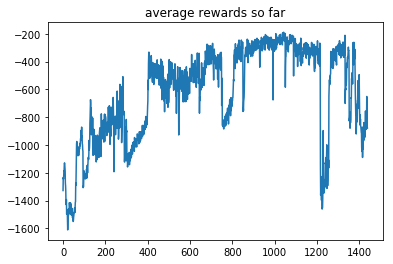

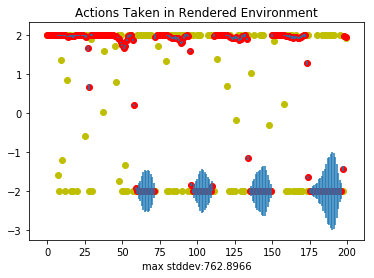

1440
average reward:  -739.0574790367098 stdevs: 173.54543 losses: 0.42482418
1441
average reward:  -760.4507064640331 stdevs: 121.99739 losses: -0.0882315
1442
average reward:  -680.6631361901216 stdevs: 141.97842 losses: 1.6794674
1443
average reward:  -722.7791964516443 stdevs: 236.21341 losses: 2.0242605
1444
average reward:  -617.5549036769677 stdevs: 140.60588 losses: -0.3945488
1445
average reward:  -552.3049286644939 stdevs: 0.04057358 losses: -0.16291617
1446
average reward:  -720.4787971449404 stdevs: 152.22592 losses: 1.8811401
1447
average reward:  -669.330804684226 stdevs: 193.15213 losses: 0.66472405
1448
average reward:  -763.2692880801881 stdevs: 99.28513 losses: 1.4831945
1449
average reward:  -756.3247624091966 stdevs: 139.97435 losses: -0.54749215
1450
average reward:  -574.6510793843212 stdevs: 175.75255 losses: 0.5493694
1451
average reward:  -644.7950996922285 stdevs: 41.907265 losses: -0.15522932
1452
average reward:  -819.7776930378981 stdevs: 166.76402 losses: 

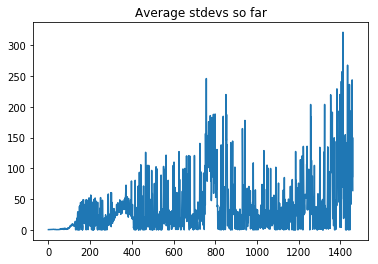

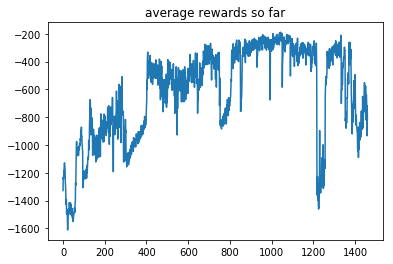

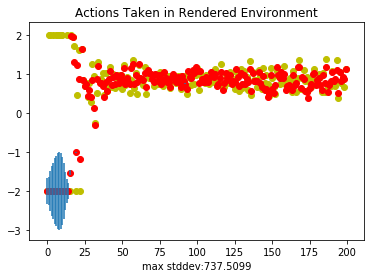

1460
average reward:  -584.4897800750093 stdevs: 73.18205 losses: -0.39468956
1461
average reward:  -575.3619434101486 stdevs: 32.378407 losses: -0.83914185
1462
average reward:  -786.4237763269209 stdevs: 118.57131 losses: 0.53181785
1463
average reward:  -640.709080000254 stdevs: 75.53527 losses: 0.009615217
1464
average reward:  -597.2376797105775 stdevs: 59.497116 losses: -0.07466544
1465
average reward:  -728.6347767881023 stdevs: 70.08128 losses: 1.5333844
1466
average reward:  -690.7120443364545 stdevs: 143.78325 losses: -0.0059553366
1467
average reward:  -755.1723783020597 stdevs: 36.049793 losses: -1.137518
1468
average reward:  -667.4064635885024 stdevs: 68.565315 losses: -0.62946117
1469
average reward:  -709.4193335300213 stdevs: 41.610264 losses: -0.70485544
1470
average reward:  -778.369415242963 stdevs: 124.066444 losses: 0.74554396
1471
average reward:  -787.0009314621925 stdevs: 42.760235 losses: -0.43048054
1472
average reward:  -779.7927669847425 stdevs: 62.28987 lo

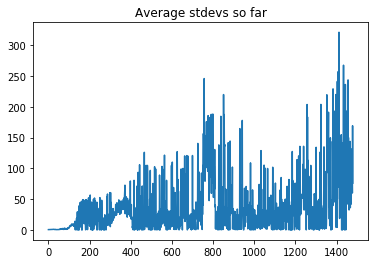

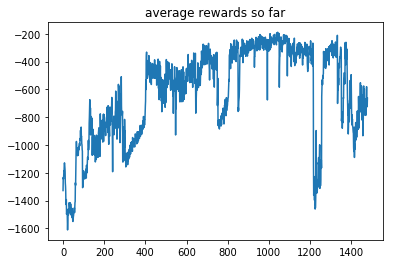

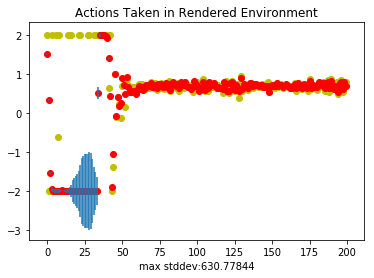

1480
average reward:  -655.1793389399594 stdevs: 88.07015 losses: -0.50689906
Saving the model after finding last 10 average rewards of: -694.1231314079092
1481
average reward:  -726.6948712400914 stdevs: 41.28965 losses: -0.51292807
1482
average reward:  -643.3690585933471 stdevs: 86.01959 losses: -0.5898347
1483
average reward:  -728.8106547019631 stdevs: 202.50377 losses: 1.2250586
1484
average reward:  -674.1640930152878 stdevs: 104.869896 losses: 0.1919632
1485
average reward:  -702.6806584694414 stdevs: 0.10844697 losses: -0.17948195
1486
average reward:  -728.594866122637 stdevs: 156.39839 losses: 0.109925315
1487
average reward:  -700.7000069849429 stdevs: 95.10763 losses: -0.20745389
1488
average reward:  -715.9496694023327 stdevs: 104.54651 losses: 1.3638434
1489
average reward:  -653.8494416261044 stdevs: 53.17062 losses: -1.0316608
1490
average reward:  -667.0053843695148 stdevs: 103.580246 losses: -0.25195548
1491
average reward:  -721.5541128440766 stdevs: 48.135216 losse

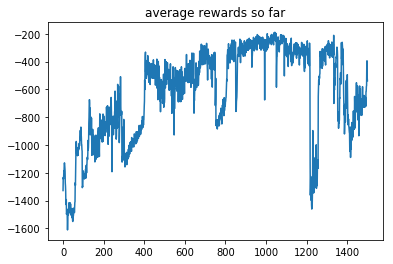

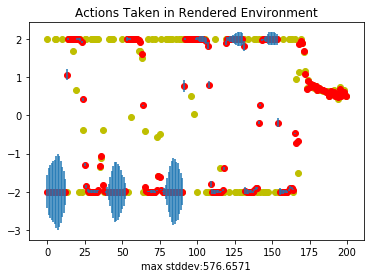

1500
average reward:  -556.9171971373295 stdevs: 87.465866 losses: 0.5430297
1501
average reward:  -532.36451376229 stdevs: 103.588646 losses: 0.5485116
1502
average reward:  -460.64666705403744 stdevs: 64.68852 losses: 0.13330564
1503
average reward:  -458.96858195910426 stdevs: 85.58994 losses: 0.3432991
1504
average reward:  -409.7599708330848 stdevs: 35.078148 losses: -0.31617197
1505
average reward:  -399.81011516341465 stdevs: 107.16974 losses: 1.5997747
1506
average reward:  -561.2031873525618 stdevs: 105.709114 losses: 1.5064102
1507
average reward:  -465.11485919505776 stdevs: 91.58519 losses: 0.8708531
1508
average reward:  -677.4045931646069 stdevs: 76.331436 losses: -0.49234188
1509
average reward:  -549.9545723028392 stdevs: 127.46258 losses: 0.19733858
1510
average reward:  -433.468741485997 stdevs: 25.712376 losses: -0.9056657
1511
average reward:  -550.1053577251382 stdevs: 16.143475 losses: 0.11457911
1512
average reward:  -343.97400748336923 stdevs: 0.43521926 losses:

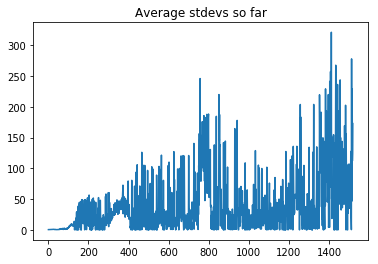

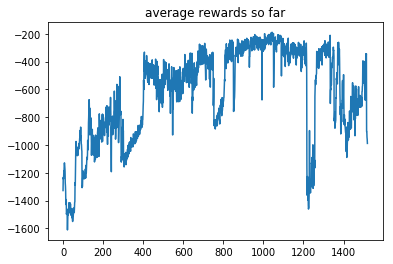

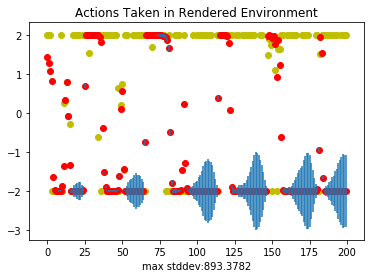

1520
average reward:  -978.5969985804493 stdevs: 255.76666 losses: 0.7031109
1521
average reward:  -984.4273164989085 stdevs: 230.18118 losses: 0.49245617
1522
average reward:  -955.5595859636054 stdevs: 189.19084 losses: 0.328959
1523
average reward:  -1014.8491100264434 stdevs: 157.80649 losses: -0.14041212
1524
average reward:  -1003.0633766781386 stdevs: 174.72157 losses: 0.012190642
1525
average reward:  -1038.9954445078922 stdevs: 51.097233 losses: 1.2404035
1526
average reward:  -998.3982106371499 stdevs: 88.315094 losses: 1.823179
1527
average reward:  -1033.7445722986135 stdevs: 216.2628 losses: -0.7204212
1528
average reward:  -1035.4576786400398 stdevs: 223.94524 losses: -0.7417978
1529
average reward:  -1051.6442139341525 stdevs: 67.74624 losses: 0.2580716
1530
average reward:  -1016.4081571983877 stdevs: 137.4227 losses: -0.44948366
1531
average reward:  -977.8282924747197 stdevs: 101.358925 losses: 0.37579247
1532
average reward:  -993.8683600475057 stdevs: 150.42111 loss

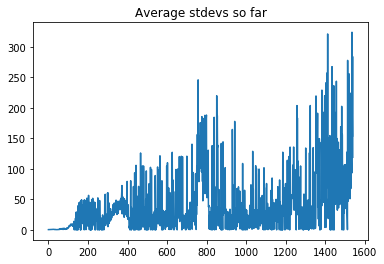

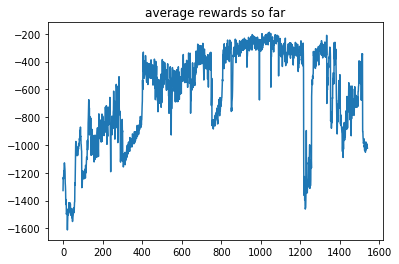

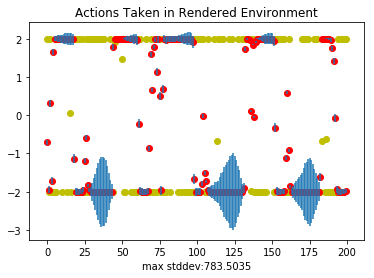

1540
average reward:  -1042.5590958735302 stdevs: 97.71588 losses: 0.9562129
1541
average reward:  -1026.202466565337 stdevs: 277.01224 losses: -0.44644147
1542
average reward:  -1030.2966701393048 stdevs: 112.21753 losses: 1.0971366
1543
average reward:  -991.6819754483582 stdevs: 169.20085 losses: 0.17832352
1544
average reward:  -1052.2561550495911 stdevs: 168.00903 losses: 0.10077101
1545
average reward:  -984.6646823612849 stdevs: 148.78174 losses: -0.099483915
1546
average reward:  -1003.8602462668478 stdevs: 198.09654 losses: -0.15494496
1547
average reward:  -1010.1368807282824 stdevs: 244.94232 losses: -0.19812526
1548
average reward:  -1022.7594584236438 stdevs: 120.61362 losses: 1.0949653
1549
average reward:  -995.8018961780069 stdevs: 197.03667 losses: -0.16827576
1550
average reward:  -1031.67358749889 stdevs: 282.86862 losses: 0.010634571
1551
average reward:  -1037.5257008923206 stdevs: 235.63159 losses: 0.29974565
1552
average reward:  -1000.3710577761367 stdevs: 215.1

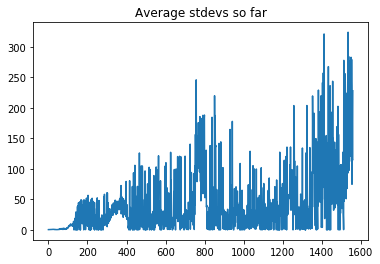

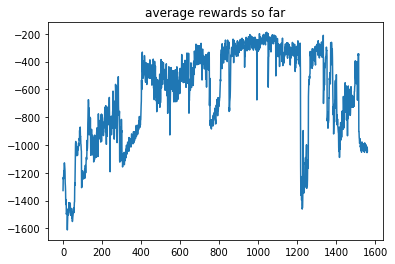

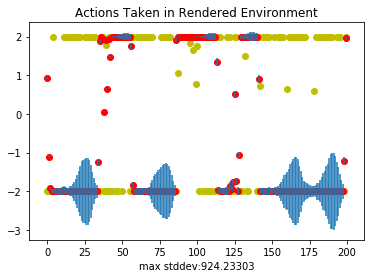

1560
average reward:  -1016.643989839216 stdevs: 132.75032 losses: 0.11456101
1561
average reward:  -1055.1984902226027 stdevs: 96.35249 losses: -1.4469916
1562
average reward:  -1022.4862251451883 stdevs: 191.20512 losses: 0.4177118
1563
average reward:  -966.1084841875185 stdevs: 170.19476 losses: -0.24573228
1564
average reward:  -1046.954952404048 stdevs: 124.58724 losses: -0.39466605
1565
average reward:  -1021.6391721722506 stdevs: 316.3087 losses: -0.5611618
1566
average reward:  -1013.9349911498812 stdevs: 146.15184 losses: -0.115328565
1567
average reward:  -1000.332610047144 stdevs: 144.5136 losses: -0.73603
1568
average reward:  -992.3624669173798 stdevs: 127.86746 losses: 0.7743804
1569
average reward:  -1014.0886010010647 stdevs: 313.90182 losses: 0.2089133
1570
average reward:  -991.7266074373754 stdevs: 202.2003 losses: -0.19736412
1571
average reward:  -1040.340978054045 stdevs: 172.09149 losses: 0.30649567
1572
average reward:  -964.9105335794832 stdevs: 271.94144 loss

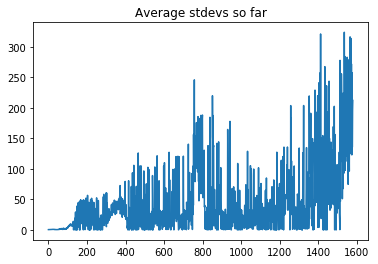

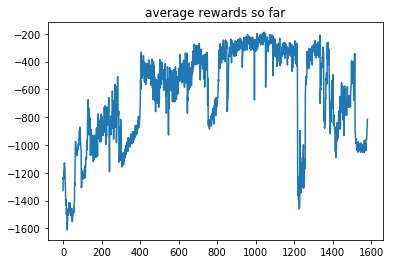

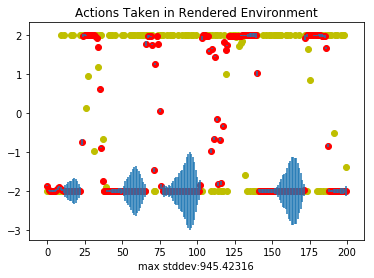

1580
average reward:  -889.8365478791738 stdevs: 116.905525 losses: 0.75228983
1581
average reward:  -810.8578516262517 stdevs: 116.599205 losses: -0.33508292
1582
average reward:  -848.6321046764366 stdevs: 86.22947 losses: -0.5507947
Saving the model after finding last 10 average rewards of: -890.8745654431775
1583
average reward:  -795.2635663676699 stdevs: 63.65939 losses: 0.21385098
1584
average reward:  -841.0623938788367 stdevs: 71.9304 losses: -0.7902026
1585
average reward:  -716.2040039526546 stdevs: 198.62378 losses: 1.1085101
1586
average reward:  -712.8067408839836 stdevs: 95.142624 losses: 0.49686167
1587
average reward:  -683.6895377263565 stdevs: 128.51462 losses: -0.46017912
1588
average reward:  -532.4437689777728 stdevs: 52.570896 losses: -1.4206045
1589
average reward:  -542.9836925299513 stdevs: 220.28165 losses: -0.12186834
1590
average reward:  -665.8616256155735 stdevs: 292.508 losses: 1.2728082
1591
average reward:  -704.7077762682925 stdevs: 108.504456 losses:

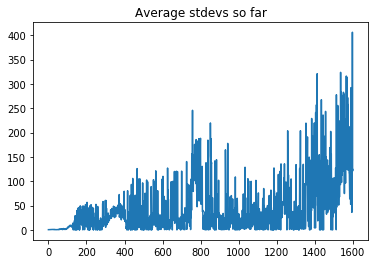

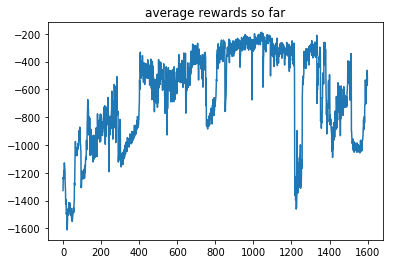

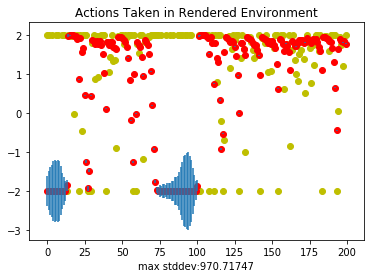

1600
average reward:  -651.3068217750622 stdevs: 65.18568 losses: -0.23411405
1601
average reward:  -508.55130376933755 stdevs: 66.93716 losses: -0.64013994
1602
average reward:  -571.3031897429564 stdevs: 7.2497005 losses: -0.07660074
1603
average reward:  -528.3150812975947 stdevs: 162.89882 losses: -0.2636193
1604
average reward:  -625.3004882501725 stdevs: 202.79477 losses: 1.7328175
1605
average reward:  -478.6488365317841 stdevs: 108.66459 losses: 0.089170255
1606
average reward:  -526.6579134354663 stdevs: 43.221046 losses: -0.3906059
1607
average reward:  -576.2524782011467 stdevs: 100.32538 losses: 0.6505367
1608
average reward:  -533.2168114666927 stdevs: 104.90941 losses: -0.30592445
1609
average reward:  -470.63894705681633 stdevs: 47.272926 losses: -1.028752
1610
average reward:  -520.4862121114822 stdevs: 47.40839 losses: -1.0628433
1611
average reward:  -594.8438741255393 stdevs: 45.525208 losses: -1.3261322
1612
average reward:  -464.6490332288163 stdevs: 195.83559 loss

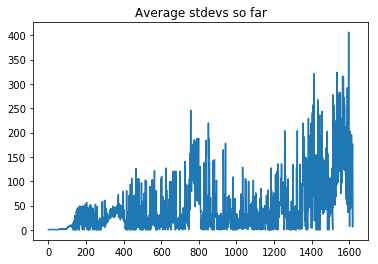

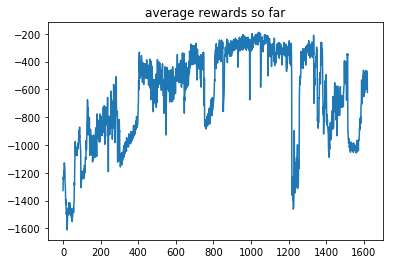

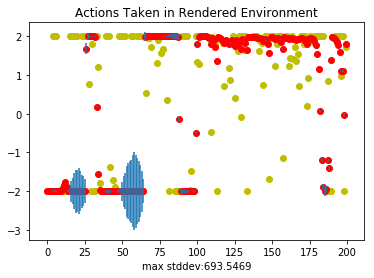

1620
average reward:  -408.3948052083962 stdevs: 197.06053 losses: 1.1281099
1621
average reward:  -525.9099448127126 stdevs: 45.608402 losses: -0.73423785
1622
average reward:  -516.9008820593419 stdevs: 255.52838 losses: 0.50954
1623
average reward:  -474.44566620589046 stdevs: 50.255093 losses: -0.5536722
1624
average reward:  -429.29632579617464 stdevs: 41.755054 losses: -0.8170157
1625
average reward:  -508.31989055203604 stdevs: 67.67755 losses: -0.5559636
1626
average reward:  -462.1990115839326 stdevs: 159.5348 losses: 0.21893288
1627
average reward:  -565.763146085583 stdevs: 63.955734 losses: -0.26837498
1628
average reward:  -519.2409293119323 stdevs: 60.583237 losses: -0.47099254
1629
average reward:  -450.2817510361773 stdevs: 182.9513 losses: -0.058286935
1630
average reward:  -445.6815206331441 stdevs: 68.03805 losses: -0.38454998
1631
average reward:  -470.3775078009197 stdevs: 58.201687 losses: -0.089627445
1632
average reward:  -577.9683685206275 stdevs: 35.292862 los

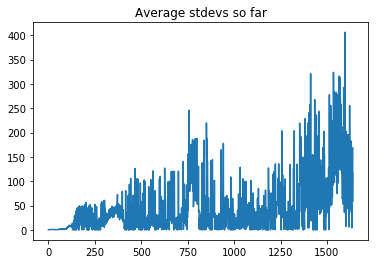

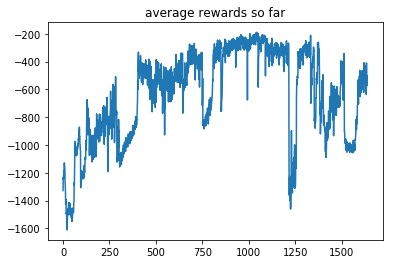

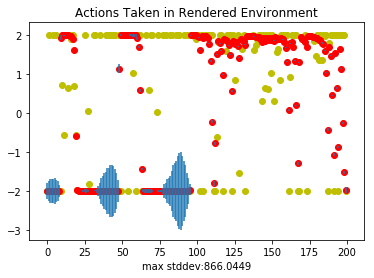

1640
average reward:  -661.7309058067653 stdevs: 67.69191 losses: -0.51745474
1641
average reward:  -531.8620753549903 stdevs: 51.687263 losses: -1.2084152
1642
average reward:  -532.7443194613936 stdevs: 79.71923 losses: -0.9840107
1643
average reward:  -421.44260316315047 stdevs: 1.5474161 losses: -0.5071262
1644
average reward:  -595.5366371608112 stdevs: 177.36417 losses: 1.4881469
1645
average reward:  -469.6179186284333 stdevs: 175.58417 losses: -0.12630135
1646
average reward:  -544.855212164304 stdevs: 68.28327 losses: -0.52199644
1647
average reward:  -457.0060142166353 stdevs: 54.688717 losses: -0.33543882
1648
average reward:  -508.5344403350443 stdevs: 14.783754 losses: 1.0658258
1649
average reward:  -520.6211174195238 stdevs: 57.849648 losses: -0.7789451
1650
average reward:  -492.8875310977128 stdevs: 82.30382 losses: -0.37160704
1651
average reward:  -516.2842323665433 stdevs: 52.668385 losses: -0.78414977
1652
average reward:  -566.0067039177239 stdevs: 134.70503 losse

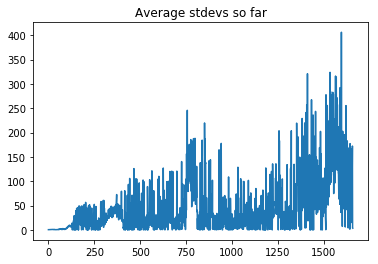

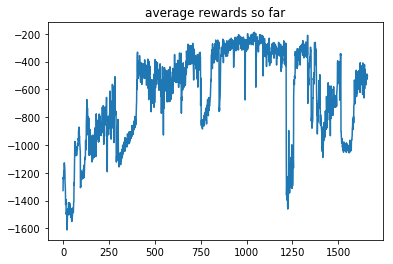

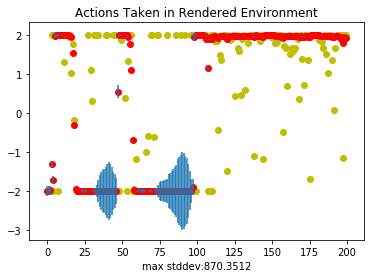

1660
average reward:  -461.28810325310826 stdevs: 57.04619 losses: -0.891098
1661
average reward:  -460.30646219480496 stdevs: 186.70418 losses: 1.2789592
1662
average reward:  -466.2868772995122 stdevs: 7.8497233 losses: -1.1784959
1663
average reward:  -458.581406593354 stdevs: 67.213715 losses: -0.33746138
1664
average reward:  -453.3829591901166 stdevs: 145.63667 losses: 0.7583369
1665
average reward:  -537.7764976811012 stdevs: 53.732216 losses: -0.9757458
1666
average reward:  -424.1981169598836 stdevs: 60.757107 losses: -0.9341659
1667
average reward:  -531.4523075914909 stdevs: 65.50188 losses: -0.51185197
1668
average reward:  -492.0707534612902 stdevs: 10.419853 losses: -0.5243051
1669
average reward:  -476.4704242685317 stdevs: 41.84714 losses: -0.4086533
1670
average reward:  -506.7448846470594 stdevs: 48.425133 losses: -0.76720566
1671
average reward:  -518.4324537019826 stdevs: 11.972914 losses: 0.58194256
1672
average reward:  -503.8014448403436 stdevs: 287.4009 losses: 

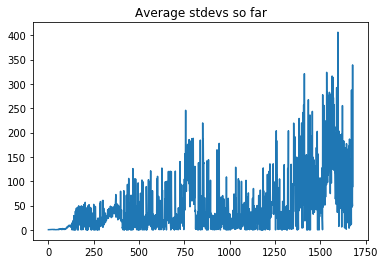

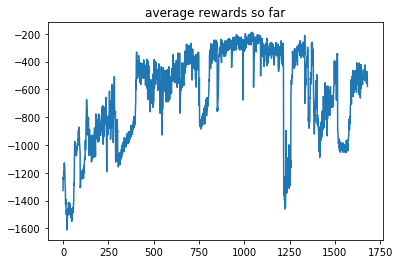

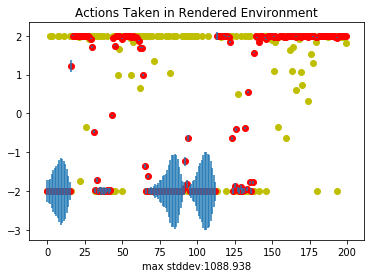

1680
average reward:  -492.1542058538804 stdevs: 36.195393 losses: -1.4245702
1681
average reward:  -523.1244139817547 stdevs: 65.512215 losses: -0.8504924
1682
average reward:  -477.3683397013826 stdevs: 50.24536 losses: -1.0384891
1683
average reward:  -519.9618141664256 stdevs: 211.20956 losses: 0.8908732
1684
average reward:  -550.9215724959988 stdevs: 129.72476 losses: -0.08639206
Saving the model after finding last 10 average rewards of: -510.2486523105798
1685
average reward:  -447.6951676285938 stdevs: 102.258125 losses: -0.5463115
1686
average reward:  -472.46684656435764 stdevs: 74.65869 losses: -0.20503554
1687
average reward:  -504.1078551182665 stdevs: 115.690956 losses: 0.21696587
1688
average reward:  -494.41594876175486 stdevs: 43.41105 losses: -0.49896002
1689
average reward:  -458.0860902358765 stdevs: 5.094234 losses: -0.9228239
1690
average reward:  -535.9616821107378 stdevs: 6.4645677 losses: -0.4563716
1691
average reward:  -441.1012779183073 stdevs: 2.5318077 los

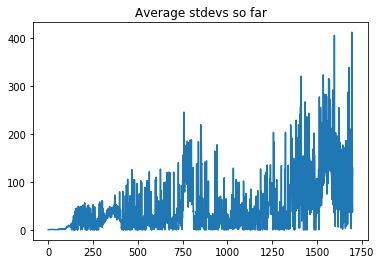

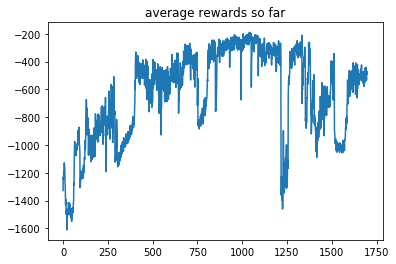

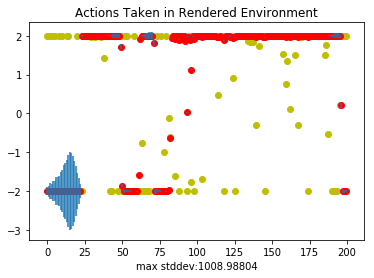

1700
average reward:  -500.26798122962043 stdevs: 8.2631235 losses: 0.2130883
1701
average reward:  -481.9013493874776 stdevs: 211.76439 losses: 0.7545334
1702
average reward:  -381.80737345891185 stdevs: 180.43181 losses: 0.25988838
1703
average reward:  -459.0012100711365 stdevs: 93.875305 losses: 0.93791795
1704
average reward:  -528.5265517544663 stdevs: 8.957156 losses: -1.3893214
1705
average reward:  -473.0817519603399 stdevs: 82.43891 losses: 0.9963333
1706
average reward:  -503.83815990769716 stdevs: 53.118267 losses: 0.49353606
1707
average reward:  -453.91942474969056 stdevs: 52.22499 losses: -0.5732203
1708
average reward:  -431.9512198500059 stdevs: 9.580934 losses: -0.5844629
1709
average reward:  -485.5039977687676 stdevs: 292.95285 losses: 0.55160636
1710
average reward:  -444.7075725198582 stdevs: 37.421547 losses: -0.641868


In [ ]:
average_rewards = []
average_stdevs = []
last_saved_at = 0
for i in range(10000):
    states, actions, rewards = accumulateData(pendulum, agent)
    #print(actions[0:10])
    #print(rewards[0:10])
    states_pro = []
    actions_pro = []
    rewards_pro = []
    discounted_rewards_pro = []
    next_states_pro = []
    last_10_average_rewards = np.average(average_rewards[-10:])
    if (len(average_rewards) > 20) and (last_10_average_rewards >= -900) and (i - last_saved_at > 50) or average_rewards[-1] >= -400:
        print("Saving the model after finding last 10 average rewards of:", last_10_average_rewards)
        save_name = "holyfuckingshit_" + str(last_10_average_rewards) + "_" + str(datetime.datetime.today()).replace(":", "-").replace(" ", "-")
        save_dir = os.path.join("checkpoints", save_name)
        saver.save(session, save_dir)
        last_saved_at = i
    elif i % 1000 == 0 and i > 0:
        save_name = "periodic_" + str(last_10_average_rewards) + "_" + str(datetime.datetime.today()).replace(":", "-").replace(" ", "-")
        save_dir = os.path.join("checkpoints", save_name)
        saver.save(session, save_dir)
    if i % 20 == 0 and i > 0:
        plt.figure()
        plt.plot(average_stdevs)
        plt.title("Average stdevs so far")
        plt.figure()
        plt.plot(average_rewards)
        plt.title("average rewards so far")

        plottable_actions, plottable_stdevs, plottable_means = renderAgent(pendulum, agent)
        plt.figure()
        max_stddev = np.max(plottable_stdevs)
        plt.errorbar(range(len(plottable_means)), plottable_means, plottable_stdevs/max_stddev, linestyle='None')
        plt.scatter(range(len(plottable_actions)), plottable_actions, color='y')
        plt.scatter(range(len(plottable_means)), plottable_means, color='r')
        plt.title("Actions Taken in Rendered Environment")
        plt.xlabel("max stddev:" + str(max_stddev))
        plt.show()
        plt.close('all')

    for j in range(len(actions)):
        ret = prepSarData(states[j], actions[j], rewards[j])
        states_pro.append(ret[0])
        actions_pro.append(ret[1])
        discounted_rewards_pro.append(ret[2])
        rewards_pro.append(ret[3])
        next_states_pro.append(ret[4])
        
        mean_reward = np.average(ret[1])
        stdev_reward = np.std(ret[1])

    for k in range(5*len(states_pro)):
        train_index = np.random.choice(a=range(len(states_pro)))
        #print("Shape of selected next states:", next_states_pro[train_index].shape)
        #print("Shape of selected states:", states_pro[train_index].shape)
        ret = agent.trainSarBatches(
            states_pro[train_index],
            actions_pro[train_index],
            discounted_rewards_pro[train_index],
            rewards_pro[train_index],
            next_states_pro[train_index]
        )
        if np.isnan(ret[0]):
            print("Received nan loss, stopping training.")
            pendulum.close()
            sys.exit(-1)
    agent.updatePrevActor()
    print(i)
    average_reward = np.average([sum(r) for r in rewards])
    print("average reward: ", average_reward, "stdevs:", np.average(np.squeeze(ret[2])), "losses:", np.average(np.squeeze(ret[0])))
    average_stdevs.append(np.average(np.squeeze(ret[2])))
    average_rewards.append(average_reward)

plt.figure()
plt.plot(average_rewards)
plt.show()
pendulum.close()